# Introduction

In this notebook I am going to train and evaluate six different models. 
The first model is my final model and an exhaustive explanation of its input and its architecture can be found in the notebook "final_solution.ipynb".

The other models take as input only the Mel Spectrograms with a window size of the fft of 512, that corresponds to 0.032s, a number of samples between successive frames of 256, and 64 mel bands.

In this way the spectrograms have a shape of 251 x 64.

The architectures are built as follws:
- Transfer learning model with EfficientNetV2B0. It is composed by the convolutional layers of EfficientNetV2B0. The output is flattened and is processed by a stack of three dense layers of respectively 512, 256, 256 neurons. Between the convolutional base and the first dense layer there is a Dropout layer to control overfitting. 

- The LSTM model is a neural echitecture, whose main components are two bidirectional LSTM layers that fully exploit the temporal informations of the spectrograms. 

- The Conv2D model is an architecture that tackle the problem as it was an image classification problem on spectrograms.

- The LSTM Conv2D model is an ensemble model, composed by the last two architectures.

- The last model is a classical transformer model with only one transformer block due to my limits in computational resources. 

# Importing dependencies and dataset

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys
import pickle
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

from Utils import AudioUtil, compile_and_train, c_report

import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Conv2D, SeparableConv2D,  Conv1D, ZeroPadding2D, Dense, Flatten, Layer, LayerNormalization, BatchNormalization , Flatten
from tensorflow.keras.layers import ReLU,ELU,  LeakyReLU, MaxPool2D, MaxPool1D, add, Dropout, SpatialDropout2D, LSTM, Bidirectional, concatenate, Activation, GlobalAveragePooling1D, MultiHeadAttention
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
main_dir=os.getcwd()
train_dir=main_dir+'\\train'
print('{}\n{}'.format(main_dir,train_dir))

train_df = pd.read_csv(main_dir+'\\2022challengeA_train.csv', index_col=0)

display(train_df[train_df.isna().any(axis=1)])
train_df = train_df.dropna()
train_df = train_df.drop([168], axis = 0)
train_df.index=range(len(train_df))

n_samples = len(train_df)

print('Number of rows: {}'.format(train_df.shape[0]))
display(train_df.sample(10))

c:\Users\david\Desktop\LOOP_Q_PRIZE
c:\Users\david\Desktop\LOOP_Q_PRIZE\train


,file_id,emotion,origin
8937,b78b41bd-3c6f-4182-94ac-430bad71f4e0.wav,NaN,tess


Number of rows: 10109


,file_id,emotion,origin
2011,86c5731c-cb2f-4acf-81d1-7f56cab04524.wav,sadness,crema
8834,89720f5b-281e-46b3-a0da-4a1b9d1288c0.wav,neutral,tess
10021,e7b68a62-2377-4c72-b75f-dbe47d8a4fad.wav,angry,tess
3194,5efc9a5e-2fe5-47ed-ac90-e12ce9b9ce67.wav,angry,crema
1586,ed123798-83cb-4cde-9014-7b87eb29fa63.wav,disgust,crema
7314,036e2288-f62b-4468-b504-0517ea2b0957.wav,angry,ravdess
9872,2787b530-c8f1-4859-8b43-6bc427763e51.wav,disgust,tess
4780,8c5f179f-9a8a-4c6b-b905-9d91de23ae5a.wav,disgust,crema
3560,4b99d9fc-b479-4863-8a69-1ac4ce51cac3.wav,fear,crema
3343,ecb3b62b-2149-464b-950a-8f98ec6a713c.wav,neutral,crema


# Multi input LSTM Model

This model is my best model. As a consequence a detailed expalation of its architecture is in a separate notebook, named 'final_solution.ipynb'

### Utils

In [ ]:

def get_data(feature):
    X = np.load('multi_input_features/'+feature+'.npy')

    y = np.load('y.npy')
    y = np.concatenate([y,y,y])


    mask_train = np.load('mask_train.npy')
    mask_val = np.load('mask_val.npy')
    mask_test = np.load('mask_test.npy')

    mask_train = np.concatenate([mask_train, mask_train + n_samples, mask_train + 2*n_samples])
    mask_val = np.concatenate([mask_val, mask_val + n_samples, mask_val + 2*n_samples])
    mask_test = np.concatenate([mask_test, mask_test + n_samples, mask_test + 2*n_samples])

    X_train, X_val, X_test, y_train, y_val, y_test = X[mask_train], X[mask_val], X[mask_test], y[mask_train], y[mask_val], y[mask_test]

    shape = X_train[0].shape

    print('Shape of the feature = ', X[0].shape)
    print('(n train, n val, n test) = ', (mask_train.shape[0], mask_val.shape[0], mask_test.shape[0]))

    return X_train, X_val, X_test, y_train, y_val, y_test

def get_lstm_model(input_shape):
    input = Input(shape = input_shape)

    x = Conv1D(32, 5, padding = 'same')(input)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPool1D(2)(x)

    x = Conv1D(32, 5, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPool1D(2)(x)

    x = Bidirectional(LSTM(32, return_sequences = True, dropout=0.3, recurrent_dropout = 0.3))(x)
    x = Bidirectional(LSTM(32, return_sequences = True, dropout=0.3, recurrent_dropout = 0.3))(x)
    x = MaxPool1D(2)(x)
    x = Flatten()(x)

    x = Dropout(0.4)(x)
    x = Dense(256, activation = 'swish')(x)
    x = Dense(256, activation = 'swish')(x)
    output = Dense(7, activation = 'softmax')(x)

    model = Model(input, output)
    return model  

### Pretraining of the models



-----------------SG-----------------


Shape of the feature =  (126, 64)
(n train, n val, n test) =  (24261, 3033, 3033)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 126, 64)]         0         
                                                                 
 conv1d_14 (Conv1D)          (None, 126, 32)           10272     
                                                                 
 batch_normalization_14 (Bat  (None, 126, 32)          128       
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 126, 32)           0         
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 63, 32)           0         
 g1D)                                                            
  

INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


759/759 [==============================] - 65s 75ms/step - loss: 1.3151 - categorical_accuracy: 0.4781 - val_loss: 1.3636 - val_categorical_accuracy: 0.4860
Epoch 2/40
759/759 [==============================] - 44s 58ms/step - loss: 1.1158 - categorical_accuracy: 0.5644 - val_loss: 1.7833 - val_categorical_accuracy: 0.4013
Epoch 3/40
759/759 [==============================] - 45s 59ms/step - loss: 1.0339 - categorical_accuracy: 0.5989 - val_loss: 1.8958 - val_categorical_accuracy: 0.3610
Epoch 4/40
759/759 [==============================] - ETA: 0s - loss: 0.9680 - categorical_accuracy: 0.6287INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


759/759 [==============================] - 58s 76ms/step - loss: 0.9680 - categorical_accuracy: 0.6287 - val_loss: 1.3716 - val_categorical_accuracy: 0.5045
Epoch 5/40
759/759 [==============================] - 46s 60ms/step - loss: 0.9243 - categorical_accuracy: 0.6444 - val_loss: 2.3452 - val_categorical_accuracy: 0.3854
Epoch 6/40
759/759 [==============================] - 44s 58ms/step - loss: 0.8764 - categorical_accuracy: 0.6610 - val_loss: 1.6787 - val_categorical_accuracy: 0.4586
Epoch 7/40
759/759 [==============================] - ETA: 0s - loss: 0.8454 - categorical_accuracy: 0.6760INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


759/759 [==============================] - 61s 80ms/step - loss: 0.8454 - categorical_accuracy: 0.6760 - val_loss: 1.3535 - val_categorical_accuracy: 0.5625
Epoch 8/40
759/759 [==============================] - 48s 63ms/step - loss: 0.8012 - categorical_accuracy: 0.6943 - val_loss: 2.2702 - val_categorical_accuracy: 0.3501
Epoch 9/40
759/759 [==============================] - ETA: 0s - loss: 0.7726 - categorical_accuracy: 0.7059INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


759/759 [==============================] - 62s 82ms/step - loss: 0.7726 - categorical_accuracy: 0.7059 - val_loss: 1.1981 - val_categorical_accuracy: 0.5786
Epoch 10/40
759/759 [==============================] - ETA: 0s - loss: 0.7432 - categorical_accuracy: 0.7182INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


759/759 [==============================] - 62s 82ms/step - loss: 0.7432 - categorical_accuracy: 0.7182 - val_loss: 1.1614 - val_categorical_accuracy: 0.6020
Epoch 11/40
759/759 [==============================] - 49s 64ms/step - loss: 0.7139 - categorical_accuracy: 0.7275 - val_loss: 1.4070 - val_categorical_accuracy: 0.5605
Epoch 12/40
759/759 [==============================] - 49s 64ms/step - loss: 0.6860 - categorical_accuracy: 0.7395 - val_loss: 1.5060 - val_categorical_accuracy: 0.5519
Epoch 13/40
759/759 [==============================] - 48s 64ms/step - loss: 0.6642 - categorical_accuracy: 0.7465 - val_loss: 1.2081 - val_categorical_accuracy: 0.6007
Epoch 14/40
759/759 [==============================] - ETA: 0s - loss: 0.6418 - categorical_accuracy: 0.7550INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


759/759 [==============================] - 62s 82ms/step - loss: 0.6418 - categorical_accuracy: 0.7550 - val_loss: 1.1748 - val_categorical_accuracy: 0.6406
Epoch 15/40
759/759 [==============================] - 49s 65ms/step - loss: 0.6152 - categorical_accuracy: 0.7684 - val_loss: 1.4669 - val_categorical_accuracy: 0.5467
Epoch 16/40
759/759 [==============================] - 49s 64ms/step - loss: 0.5955 - categorical_accuracy: 0.7731 - val_loss: 1.1879 - val_categorical_accuracy: 0.6123
Epoch 17/40
759/759 [==============================] - 49s 64ms/step - loss: 0.5688 - categorical_accuracy: 0.7837 - val_loss: 1.3553 - val_categorical_accuracy: 0.5928
Epoch 18/40
759/759 [==============================] - 49s 65ms/step - loss: 0.5558 - categorical_accuracy: 0.7874 - val_loss: 1.5330 - val_categorical_accuracy: 0.5895
Epoch 19/40
759/759 [==============================] - 49s 64ms/step - loss: 0.5329 - categorical_accuracy: 0.7955 - val_loss: 1.5769 - val_categorical_accuracy: 0.570

INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


759/759 [==============================] - 61s 81ms/step - loss: 0.5025 - categorical_accuracy: 0.8113 - val_loss: 1.1974 - val_categorical_accuracy: 0.6518
Epoch 22/40
759/759 [==============================] - 48s 64ms/step - loss: 0.4893 - categorical_accuracy: 0.8141 - val_loss: 1.5740 - val_categorical_accuracy: 0.5509
Epoch 23/40
759/759 [==============================] - 50s 66ms/step - loss: 0.4708 - categorical_accuracy: 0.8213 - val_loss: 1.4031 - val_categorical_accuracy: 0.6353
Epoch 24/40
759/759 [==============================] - 49s 65ms/step - loss: 0.4572 - categorical_accuracy: 0.8252 - val_loss: 3.0944 - val_categorical_accuracy: 0.4652
Epoch 25/40
759/759 [==============================] - 49s 65ms/step - loss: 0.4436 - categorical_accuracy: 0.8331 - val_loss: 1.4321 - val_categorical_accuracy: 0.6212
Epoch 26/40
759/759 [==============================] - 49s 65ms/step - loss: 0.4239 - categorical_accuracy: 0.8392 - val_loss: 1.2582 - val_categorical_accuracy: 0.629

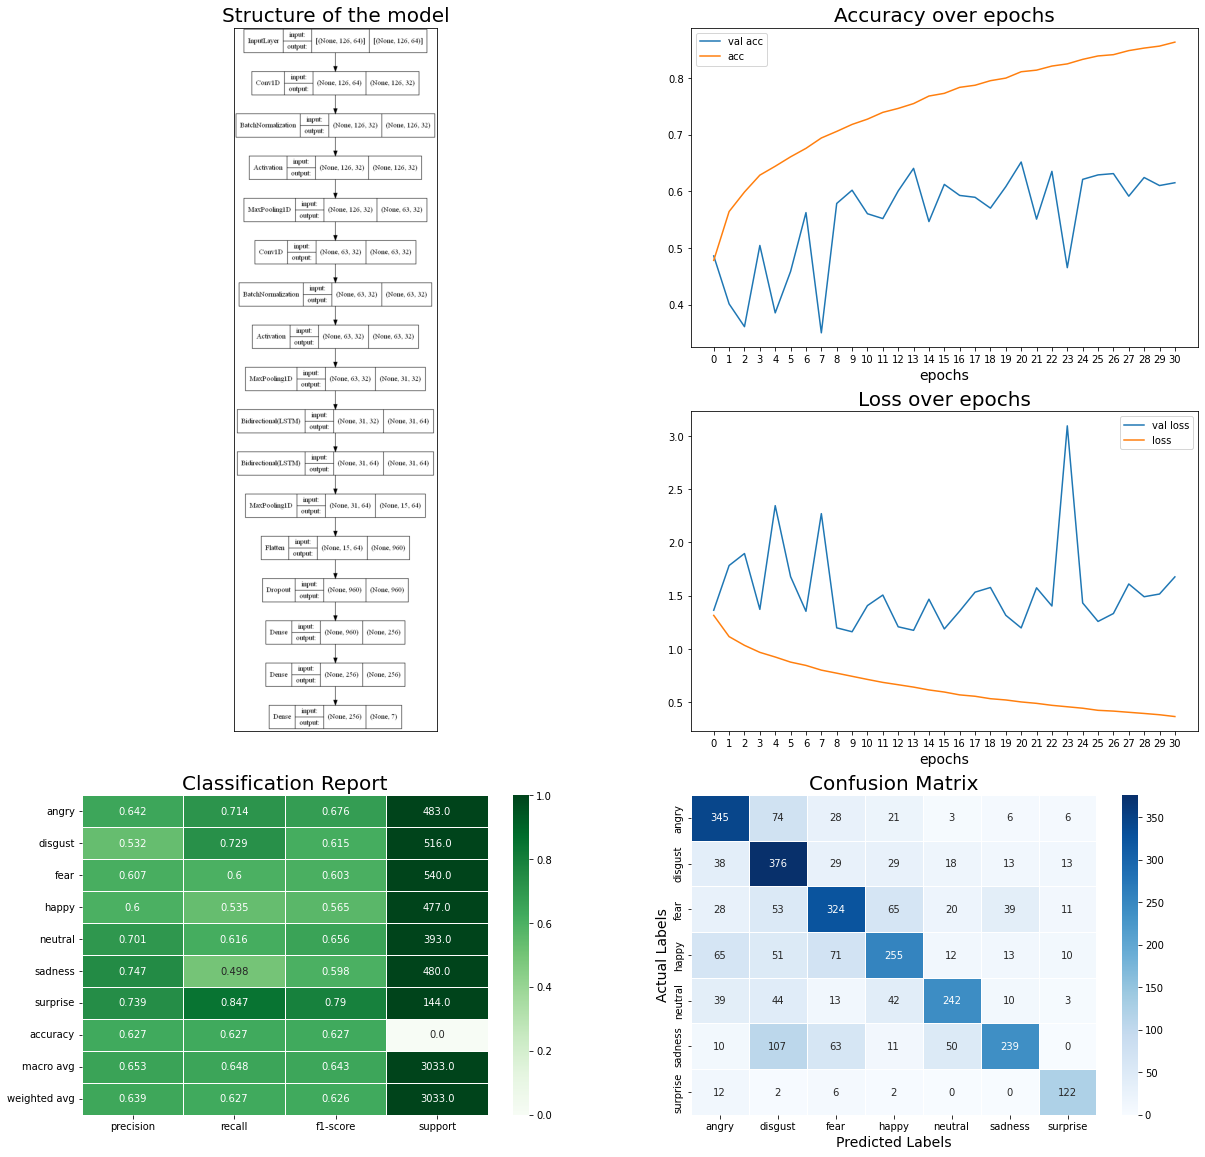



-----------------END-----------------




-----------------MF-----------------


Shape of the feature =  (126, 20)
(n train, n val, n test) =  (24261, 3033, 3033)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 126, 20)]         0         
                                                                 
 conv1d_16 (Conv1D)          (None, 126, 32)           3232      
                                                                 
 batch_normalization_16 (Bat  (None, 126, 32)          128       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 126, 32)           0         
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 63, 32)           0         
 g1D)                     

INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


759/759 [==============================] - 77s 92ms/step - loss: 1.3047 - categorical_accuracy: 0.4843 - val_loss: 1.3399 - val_categorical_accuracy: 0.4655
Epoch 2/40
759/759 [==============================] - ETA: 0s - loss: 1.0803 - categorical_accuracy: 0.5766INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


759/759 [==============================] - 64s 84ms/step - loss: 1.0803 - categorical_accuracy: 0.5766 - val_loss: 1.4222 - val_categorical_accuracy: 0.5147
Epoch 3/40
759/759 [==============================] - ETA: 0s - loss: 1.0090 - categorical_accuracy: 0.6088INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


759/759 [==============================] - 66s 87ms/step - loss: 1.0090 - categorical_accuracy: 0.6088 - val_loss: 1.1450 - val_categorical_accuracy: 0.5595
Epoch 4/40
759/759 [==============================] - ETA: 0s - loss: 0.9449 - categorical_accuracy: 0.6342INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


759/759 [==============================] - 68s 90ms/step - loss: 0.9449 - categorical_accuracy: 0.6342 - val_loss: 1.1301 - val_categorical_accuracy: 0.5605
Epoch 5/40
759/759 [==============================] - ETA: 0s - loss: 0.8966 - categorical_accuracy: 0.6523INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


759/759 [==============================] - 67s 88ms/step - loss: 0.8966 - categorical_accuracy: 0.6523 - val_loss: 1.0770 - val_categorical_accuracy: 0.5862
Epoch 6/40
759/759 [==============================] - ETA: 0s - loss: 0.8557 - categorical_accuracy: 0.6738INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


759/759 [==============================] - 67s 88ms/step - loss: 0.8557 - categorical_accuracy: 0.6738 - val_loss: 0.9606 - val_categorical_accuracy: 0.6261
Epoch 7/40
759/759 [==============================] - 55s 72ms/step - loss: 0.8328 - categorical_accuracy: 0.6818 - val_loss: 1.0056 - val_categorical_accuracy: 0.6185
Epoch 8/40
759/759 [==============================] - ETA: 0s - loss: 0.7924 - categorical_accuracy: 0.6942INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


759/759 [==============================] - 70s 92ms/step - loss: 0.7924 - categorical_accuracy: 0.6942 - val_loss: 1.0255 - val_categorical_accuracy: 0.6314
Epoch 9/40
759/759 [==============================] - 55s 73ms/step - loss: 0.7677 - categorical_accuracy: 0.7043 - val_loss: 1.0616 - val_categorical_accuracy: 0.6258
Epoch 10/40
759/759 [==============================] - 56s 73ms/step - loss: 0.7316 - categorical_accuracy: 0.7184 - val_loss: 1.0485 - val_categorical_accuracy: 0.6255
Epoch 11/40
759/759 [==============================] - 56s 73ms/step - loss: 0.7102 - categorical_accuracy: 0.7273 - val_loss: 1.0583 - val_categorical_accuracy: 0.6261
Epoch 12/40
759/759 [==============================] - 55s 73ms/step - loss: 0.6798 - categorical_accuracy: 0.7372 - val_loss: 1.0343 - val_categorical_accuracy: 0.6202
Epoch 13/40
759/759 [==============================] - ETA: 0s - loss: 0.6597 - categorical_accuracy: 0.7450INFO:tensorflow:Assets written to: models/big_r\lstm_mf\asse

INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


759/759 [==============================] - 68s 90ms/step - loss: 0.6597 - categorical_accuracy: 0.7450 - val_loss: 1.0592 - val_categorical_accuracy: 0.6429
Epoch 14/40
759/759 [==============================] - 53s 70ms/step - loss: 0.6251 - categorical_accuracy: 0.7612 - val_loss: 1.1939 - val_categorical_accuracy: 0.6222
Epoch 15/40
759/759 [==============================] - 55s 72ms/step - loss: 0.6103 - categorical_accuracy: 0.7652 - val_loss: 1.1113 - val_categorical_accuracy: 0.6294
Epoch 16/40
759/759 [==============================] - 54s 71ms/step - loss: 0.5853 - categorical_accuracy: 0.7738 - val_loss: 1.2020 - val_categorical_accuracy: 0.6278
Epoch 17/40
759/759 [==============================] - 55s 72ms/step - loss: 0.5636 - categorical_accuracy: 0.7821 - val_loss: 1.1586 - val_categorical_accuracy: 0.6344
Epoch 18/40
759/759 [==============================] - 55s 72ms/step - loss: 0.5539 - categorical_accuracy: 0.7909 - val_loss: 1.1326 - val_categorical_accuracy: 0.628

INFO:tensorflow:Assets written to: models/big_r\lstm_mf\assets


759/759 [==============================] - 69s 91ms/step - loss: 0.5368 - categorical_accuracy: 0.7961 - val_loss: 1.1624 - val_categorical_accuracy: 0.6495
Epoch 20/40
759/759 [==============================] - 54s 71ms/step - loss: 0.5131 - categorical_accuracy: 0.8043 - val_loss: 1.2990 - val_categorical_accuracy: 0.6225
Epoch 21/40
759/759 [==============================] - 54s 72ms/step - loss: 0.4959 - categorical_accuracy: 0.8097 - val_loss: 1.4333 - val_categorical_accuracy: 0.6195
Epoch 22/40
759/759 [==============================] - 55s 72ms/step - loss: 0.4846 - categorical_accuracy: 0.8134 - val_loss: 1.1823 - val_categorical_accuracy: 0.6396
Epoch 23/40
759/759 [==============================] - 56s 74ms/step - loss: 0.4686 - categorical_accuracy: 0.8177 - val_loss: 1.3250 - val_categorical_accuracy: 0.6281
Epoch 24/40
759/759 [==============================] - 54s 72ms/step - loss: 0.4500 - categorical_accuracy: 0.8291 - val_loss: 1.2505 - val_categorical_accuracy: 0.644

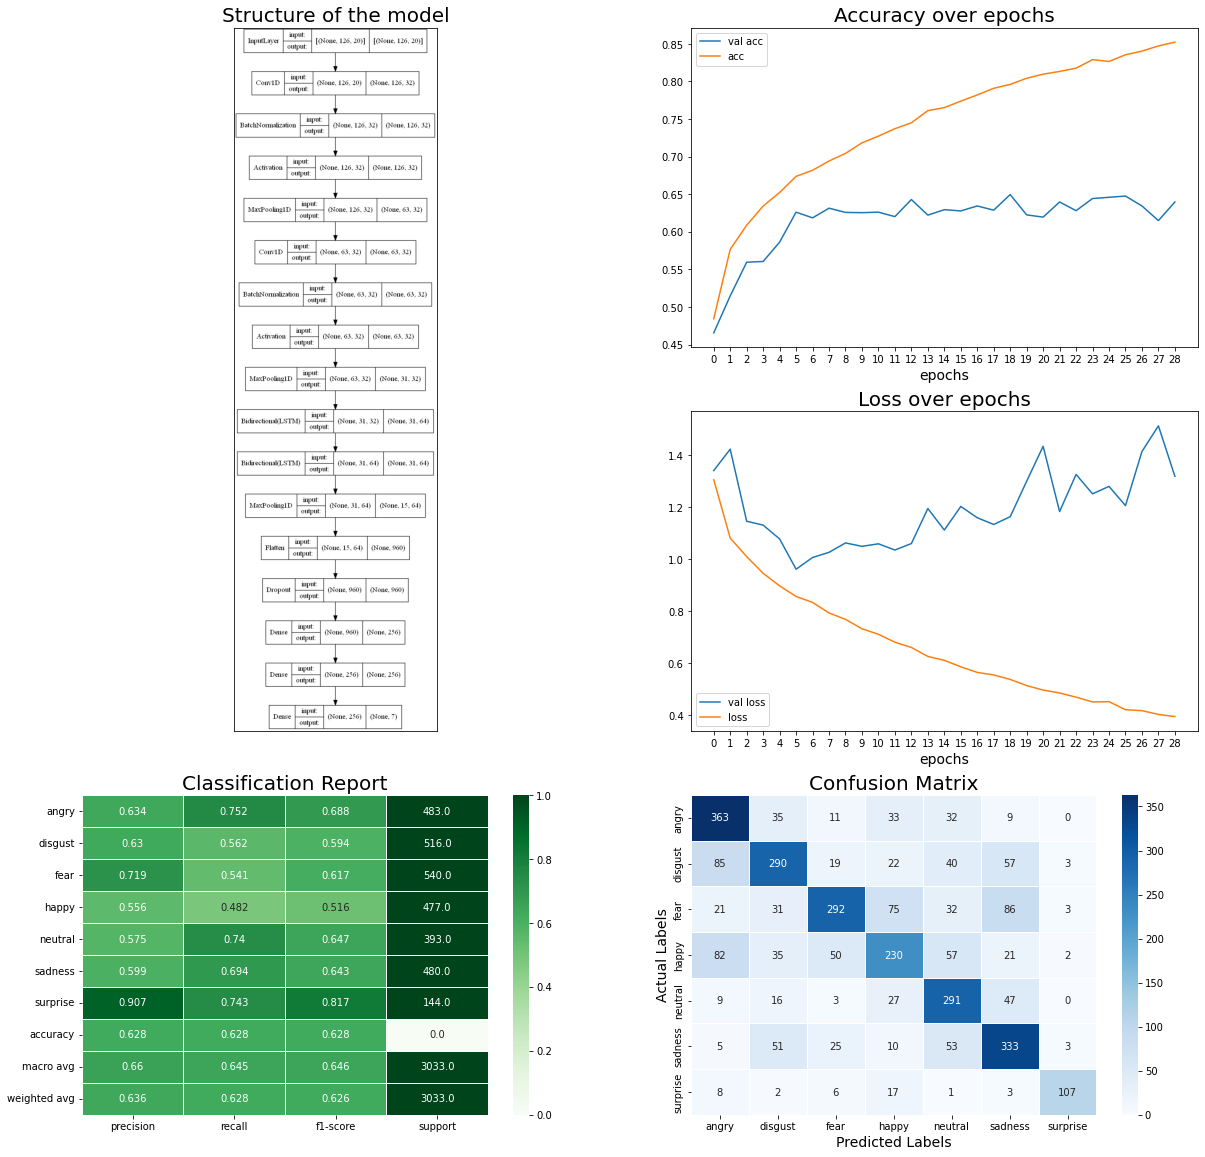



-----------------END-----------------




-----------------CG-----------------


Shape of the feature =  (126, 12)
(n train, n val, n test) =  (24261, 3033, 3033)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 126, 12)]         0         
                                                                 
 conv1d_18 (Conv1D)          (None, 126, 32)           1952      
                                                                 
 batch_normalization_18 (Bat  (None, 126, 32)          128       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 126, 32)           0         
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 63, 32)           0         
 g1D)                     

INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


759/759 [==============================] - 75s 89ms/step - loss: 1.4045 - categorical_accuracy: 0.4228 - val_loss: 1.9044 - val_categorical_accuracy: 0.3755
Epoch 2/40
759/759 [==============================] - ETA: 0s - loss: 1.2058 - categorical_accuracy: 0.5118INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


759/759 [==============================] - 67s 88ms/step - loss: 1.2058 - categorical_accuracy: 0.5118 - val_loss: 2.0677 - val_categorical_accuracy: 0.3841
Epoch 3/40
759/759 [==============================] - ETA: 0s - loss: 1.1445 - categorical_accuracy: 0.5436INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


759/759 [==============================] - 68s 89ms/step - loss: 1.1445 - categorical_accuracy: 0.5436 - val_loss: 1.2379 - val_categorical_accuracy: 0.5282
Epoch 4/40
759/759 [==============================] - ETA: 0s - loss: 1.0969 - categorical_accuracy: 0.5631INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


759/759 [==============================] - 67s 88ms/step - loss: 1.0969 - categorical_accuracy: 0.5631 - val_loss: 1.1426 - val_categorical_accuracy: 0.5440
Epoch 5/40
759/759 [==============================] - 53s 70ms/step - loss: 1.0540 - categorical_accuracy: 0.5854 - val_loss: 1.2847 - val_categorical_accuracy: 0.4969
Epoch 6/40
759/759 [==============================] - 55s 72ms/step - loss: 1.0184 - categorical_accuracy: 0.6004 - val_loss: 1.4343 - val_categorical_accuracy: 0.4679
Epoch 7/40
759/759 [==============================] - ETA: 0s - loss: 0.9924 - categorical_accuracy: 0.6102INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


759/759 [==============================] - 71s 94ms/step - loss: 0.9924 - categorical_accuracy: 0.6102 - val_loss: 1.1558 - val_categorical_accuracy: 0.5598
Epoch 8/40
759/759 [==============================] - ETA: 0s - loss: 0.9559 - categorical_accuracy: 0.6261INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


759/759 [==============================] - 70s 92ms/step - loss: 0.9559 - categorical_accuracy: 0.6261 - val_loss: 1.1674 - val_categorical_accuracy: 0.5727
Epoch 9/40
759/759 [==============================] - ETA: 0s - loss: 0.9322 - categorical_accuracy: 0.6346INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_cg\assets


759/759 [==============================] - 71s 94ms/step - loss: 0.9322 - categorical_accuracy: 0.6346 - val_loss: 1.1244 - val_categorical_accuracy: 0.5865
Epoch 10/40
759/759 [==============================] - 55s 73ms/step - loss: 0.8927 - categorical_accuracy: 0.6537 - val_loss: 1.3309 - val_categorical_accuracy: 0.5391
Epoch 11/40
759/759 [==============================] - 56s 74ms/step - loss: 0.8624 - categorical_accuracy: 0.6639 - val_loss: 1.3079 - val_categorical_accuracy: 0.5391
Epoch 12/40
759/759 [==============================] - 56s 74ms/step - loss: 0.8420 - categorical_accuracy: 0.6755 - val_loss: 1.2191 - val_categorical_accuracy: 0.5562
Epoch 13/40
759/759 [==============================] - 57s 74ms/step - loss: 0.8173 - categorical_accuracy: 0.6858 - val_loss: 1.2337 - val_categorical_accuracy: 0.5674
Epoch 14/40
759/759 [==============================] - 56s 74ms/step - loss: 0.7901 - categorical_accuracy: 0.6951 - val_loss: 1.5044 - val_categorical_accuracy: 0.506

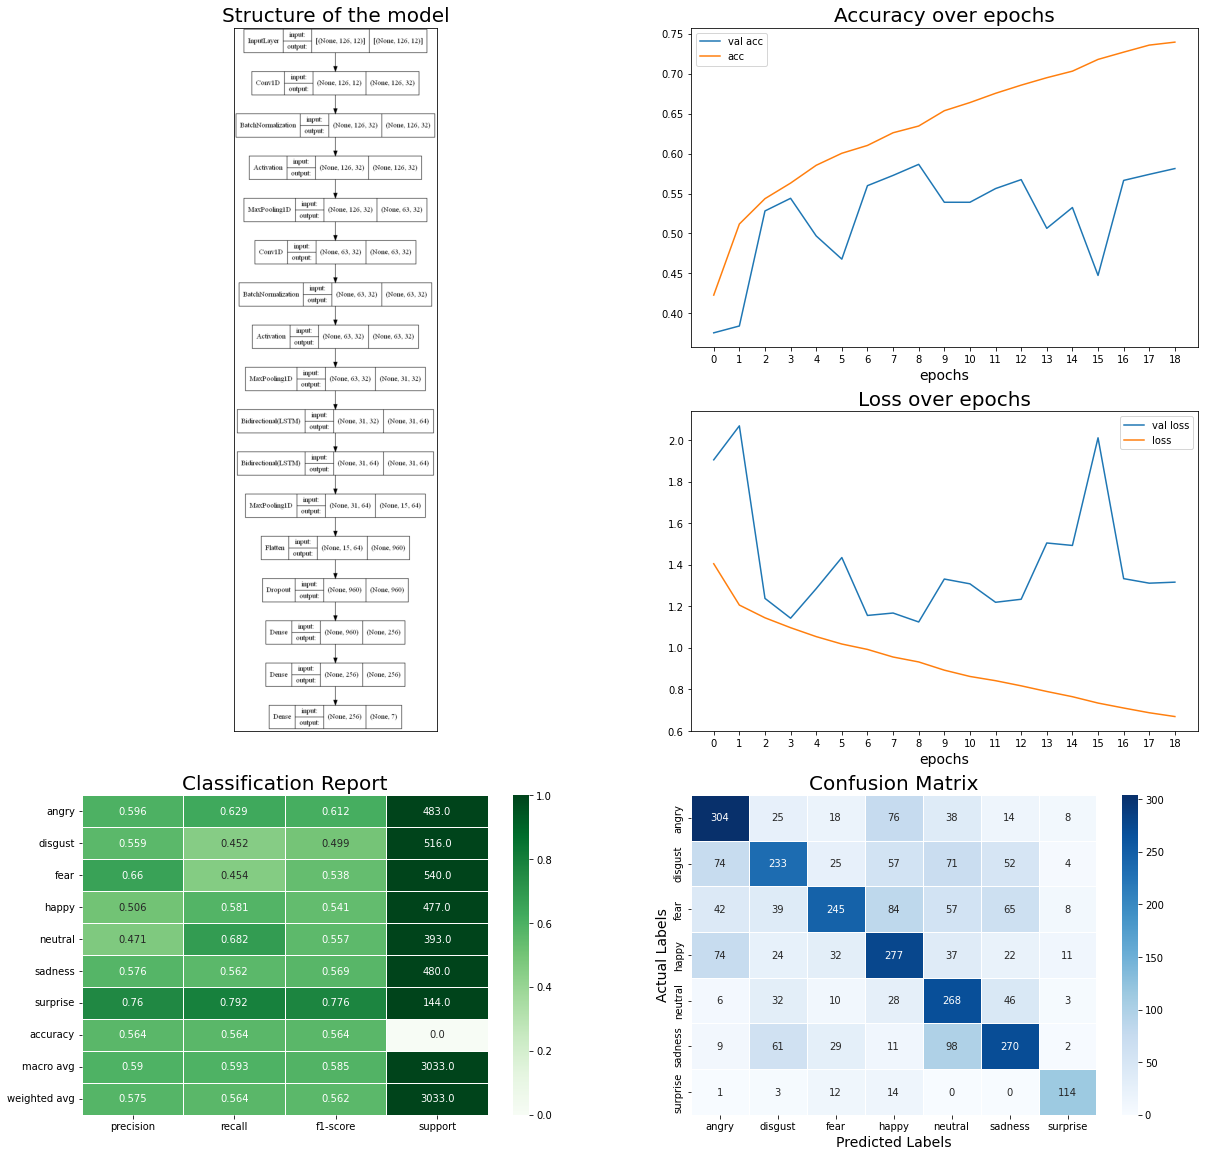



-----------------END-----------------




-----------------TN-----------------


Shape of the feature =  (126, 6)
(n train, n val, n test) =  (24261, 3033, 3033)
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 126, 6)]          0         
                                                                 
 conv1d_20 (Conv1D)          (None, 126, 32)           992       
                                                                 
 batch_normalization_20 (Bat  (None, 126, 32)          128       
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 126, 32)           0         
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 63, 32)           0         
 g1D)                      

INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


759/759 [==============================] - 76s 90ms/step - loss: 1.5237 - categorical_accuracy: 0.3713 - val_loss: 1.4093 - val_categorical_accuracy: 0.4230
Epoch 2/40
759/759 [==============================] - ETA: 0s - loss: 1.3265 - categorical_accuracy: 0.4544INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


759/759 [==============================] - 67s 88ms/step - loss: 1.3265 - categorical_accuracy: 0.4544 - val_loss: 1.4138 - val_categorical_accuracy: 0.4286
Epoch 3/40
759/759 [==============================] - ETA: 0s - loss: 1.2602 - categorical_accuracy: 0.4872INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


759/759 [==============================] - 68s 89ms/step - loss: 1.2602 - categorical_accuracy: 0.4872 - val_loss: 1.2746 - val_categorical_accuracy: 0.4916
Epoch 4/40
759/759 [==============================] - ETA: 0s - loss: 1.2029 - categorical_accuracy: 0.5150INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


759/759 [==============================] - 68s 90ms/step - loss: 1.2029 - categorical_accuracy: 0.5150 - val_loss: 1.2580 - val_categorical_accuracy: 0.4952
Epoch 5/40
759/759 [==============================] - 61s 80ms/step - loss: 1.1683 - categorical_accuracy: 0.5323 - val_loss: 1.6284 - val_categorical_accuracy: 0.4006
Epoch 6/40
759/759 [==============================] - 61s 81ms/step - loss: 1.1368 - categorical_accuracy: 0.5454 - val_loss: 1.5160 - val_categorical_accuracy: 0.4402
Epoch 7/40
759/759 [==============================] - 60s 79ms/step - loss: 1.1106 - categorical_accuracy: 0.5586 - val_loss: 1.3566 - val_categorical_accuracy: 0.4903
Epoch 8/40
759/759 [==============================] - 61s 80ms/step - loss: 1.0791 - categorical_accuracy: 0.5630 - val_loss: 1.3782 - val_categorical_accuracy: 0.4837
Epoch 9/40
759/759 [==============================] - 61s 80ms/step - loss: 1.0570 - categorical_accuracy: 0.5810 - val_loss: 1.4232 - val_categorical_accuracy: 0.4758
Epo

INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


759/759 [==============================] - 73s 97ms/step - loss: 1.0378 - categorical_accuracy: 0.5822 - val_loss: 1.3439 - val_categorical_accuracy: 0.4965
Epoch 11/40
759/759 [==============================] - 60s 79ms/step - loss: 1.0024 - categorical_accuracy: 0.5999 - val_loss: 1.5309 - val_categorical_accuracy: 0.4708
Epoch 12/40
759/759 [==============================] - ETA: 0s - loss: 0.9784 - categorical_accuracy: 0.6093INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


759/759 [==============================] - 74s 97ms/step - loss: 0.9784 - categorical_accuracy: 0.6093 - val_loss: 1.3517 - val_categorical_accuracy: 0.5157
Epoch 13/40
759/759 [==============================] - ETA: 0s - loss: 0.9669 - categorical_accuracy: 0.6151INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


759/759 [==============================] - 74s 97ms/step - loss: 0.9669 - categorical_accuracy: 0.6151 - val_loss: 1.2315 - val_categorical_accuracy: 0.5259
Epoch 14/40
759/759 [==============================] - ETA: 0s - loss: 0.9381 - categorical_accuracy: 0.6294INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


759/759 [==============================] - 76s 100ms/step - loss: 0.9381 - categorical_accuracy: 0.6294 - val_loss: 1.3209 - val_categorical_accuracy: 0.5295
Epoch 15/40
759/759 [==============================] - 62s 81ms/step - loss: 0.9152 - categorical_accuracy: 0.6349 - val_loss: 1.3137 - val_categorical_accuracy: 0.5203
Epoch 16/40
759/759 [==============================] - 62s 82ms/step - loss: 0.8953 - categorical_accuracy: 0.6461 - val_loss: 1.2881 - val_categorical_accuracy: 0.5203
Epoch 17/40
759/759 [==============================] - ETA: 0s - loss: 0.8747 - categorical_accuracy: 0.6566INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_tn\assets


759/759 [==============================] - 77s 101ms/step - loss: 0.8747 - categorical_accuracy: 0.6566 - val_loss: 1.3143 - val_categorical_accuracy: 0.5345
Epoch 18/40
759/759 [==============================] - 62s 82ms/step - loss: 0.8574 - categorical_accuracy: 0.6628 - val_loss: 1.2810 - val_categorical_accuracy: 0.5275
Epoch 19/40
759/759 [==============================] - 65s 86ms/step - loss: 0.8336 - categorical_accuracy: 0.6714 - val_loss: 1.6676 - val_categorical_accuracy: 0.4850
Epoch 20/40
759/759 [==============================] - 63s 83ms/step - loss: 0.8144 - categorical_accuracy: 0.6825 - val_loss: 1.3580 - val_categorical_accuracy: 0.5183
Epoch 21/40
759/759 [==============================] - 63s 83ms/step - loss: 0.7991 - categorical_accuracy: 0.6839 - val_loss: 1.4838 - val_categorical_accuracy: 0.5094
Epoch 22/40
759/759 [==============================] - 63s 83ms/step - loss: 0.7748 - categorical_accuracy: 0.6959 - val_loss: 1.3521 - val_categorical_accuracy: 0.52

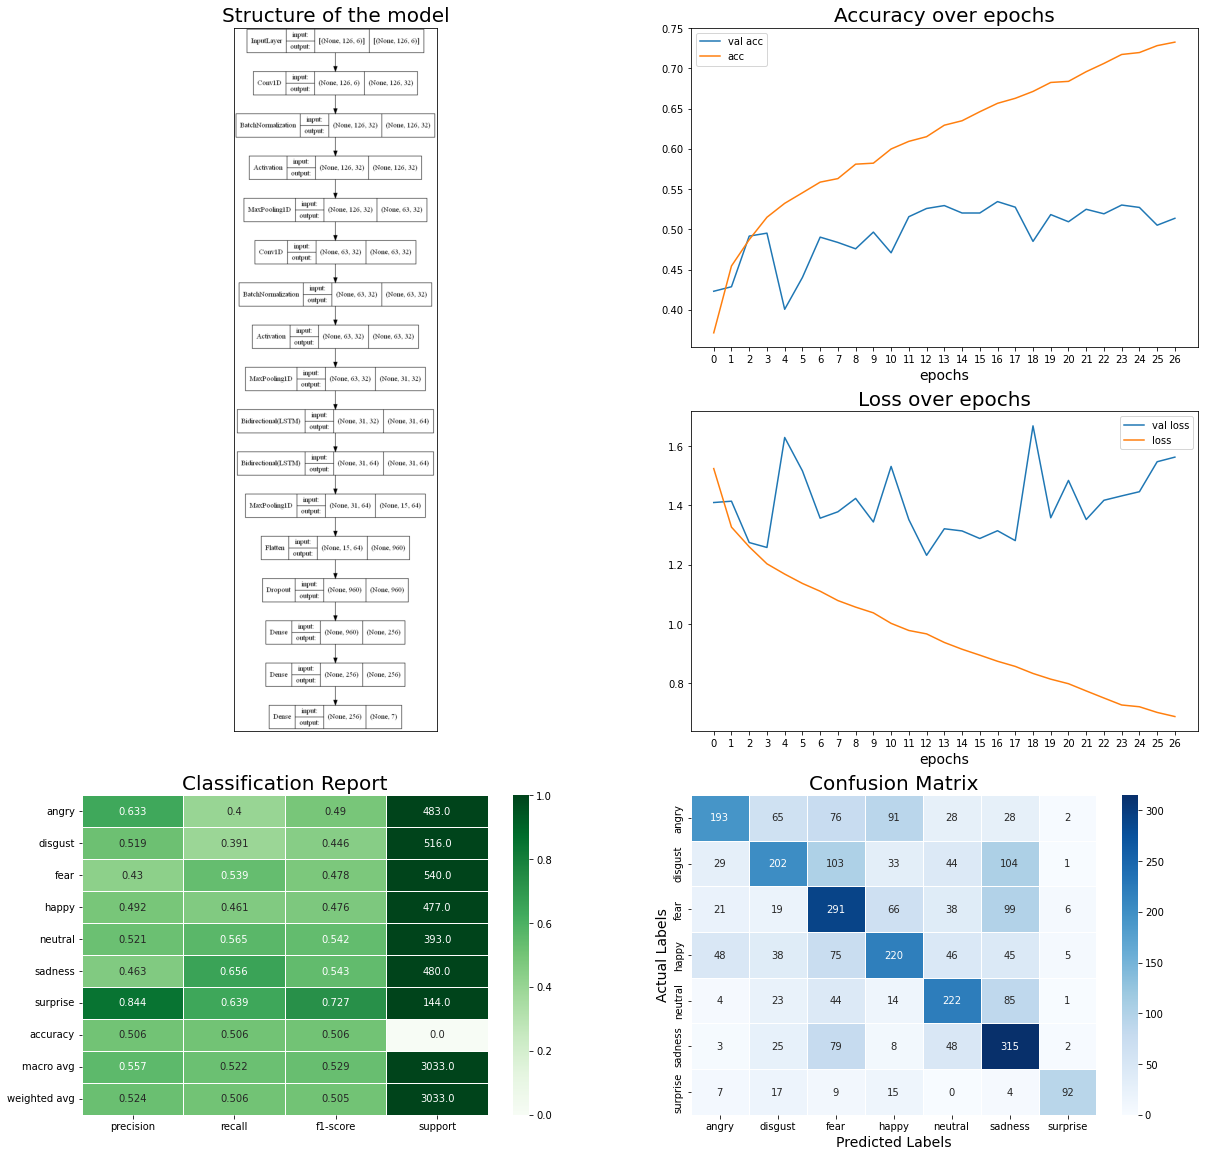



-----------------END-----------------




-----------------SC-----------------


Shape of the feature =  (126, 7)
(n train, n val, n test) =  (24261, 3033, 3033)
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 126, 7)]          0         
                                                                 
 conv1d_22 (Conv1D)          (None, 126, 32)           1152      
                                                                 
 batch_normalization_22 (Bat  (None, 126, 32)          128       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 126, 32)           0         
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 63, 32)           0         
 g1D)                     

INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


759/759 [==============================] - 85s 102ms/step - loss: 1.5894 - categorical_accuracy: 0.3479 - val_loss: 1.5830 - val_categorical_accuracy: 0.3584
Epoch 2/40
759/759 [==============================] - ETA: 0s - loss: 1.3479 - categorical_accuracy: 0.4557INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


759/759 [==============================] - 75s 99ms/step - loss: 1.3479 - categorical_accuracy: 0.4557 - val_loss: 1.3348 - val_categorical_accuracy: 0.4563
Epoch 3/40
759/759 [==============================] - 63s 84ms/step - loss: 1.2541 - categorical_accuracy: 0.4949 - val_loss: 1.4523 - val_categorical_accuracy: 0.4411
Epoch 4/40
759/759 [==============================] - ETA: 0s - loss: 1.2053 - categorical_accuracy: 0.5198INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


759/759 [==============================] - 76s 100ms/step - loss: 1.2053 - categorical_accuracy: 0.5198 - val_loss: 1.1885 - val_categorical_accuracy: 0.5173
Epoch 5/40
759/759 [==============================] - ETA: 0s - loss: 1.1640 - categorical_accuracy: 0.5363INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


759/759 [==============================] - 76s 100ms/step - loss: 1.1640 - categorical_accuracy: 0.5363 - val_loss: 1.1848 - val_categorical_accuracy: 0.5354
Epoch 6/40
759/759 [==============================] - 66s 86ms/step - loss: 1.1416 - categorical_accuracy: 0.5487 - val_loss: 1.2277 - val_categorical_accuracy: 0.5077
Epoch 7/40
759/759 [==============================] - 68s 90ms/step - loss: 1.1099 - categorical_accuracy: 0.5591 - val_loss: 1.3957 - val_categorical_accuracy: 0.4768
Epoch 8/40
759/759 [==============================] - 68s 90ms/step - loss: 1.0818 - categorical_accuracy: 0.5719 - val_loss: 1.2840 - val_categorical_accuracy: 0.5074
Epoch 9/40
759/759 [==============================] - ETA: 0s - loss: 1.0708 - categorical_accuracy: 0.5789INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


759/759 [==============================] - 84s 111ms/step - loss: 1.0708 - categorical_accuracy: 0.5789 - val_loss: 1.1781 - val_categorical_accuracy: 0.5407
Epoch 10/40
759/759 [==============================] - 69s 91ms/step - loss: 1.0448 - categorical_accuracy: 0.5874 - val_loss: 1.3007 - val_categorical_accuracy: 0.4959
Epoch 11/40
759/759 [==============================] - 71s 93ms/step - loss: 1.0277 - categorical_accuracy: 0.5891 - val_loss: 1.1855 - val_categorical_accuracy: 0.5401
Epoch 12/40
759/759 [==============================] - 70s 92ms/step - loss: 1.0015 - categorical_accuracy: 0.6077 - val_loss: 1.1816 - val_categorical_accuracy: 0.5351
Epoch 13/40
759/759 [==============================] - 69s 91ms/step - loss: 0.9914 - categorical_accuracy: 0.6102 - val_loss: 1.4225 - val_categorical_accuracy: 0.4880
Epoch 14/40
759/759 [==============================] - ETA: 0s - loss: 0.9663 - categorical_accuracy: 0.6233INFO:tensorflow:Assets written to: models/big_r\lstm_sc\as

INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


759/759 [==============================] - 84s 111ms/step - loss: 0.9663 - categorical_accuracy: 0.6233 - val_loss: 1.2025 - val_categorical_accuracy: 0.5434
Epoch 15/40
759/759 [==============================] - 74s 98ms/step - loss: 0.9484 - categorical_accuracy: 0.6277 - val_loss: 1.2426 - val_categorical_accuracy: 0.5312
Epoch 16/40
759/759 [==============================] - 75s 99ms/step - loss: 0.9288 - categorical_accuracy: 0.6366 - val_loss: 1.3070 - val_categorical_accuracy: 0.5203
Epoch 17/40
759/759 [==============================] - 66s 86ms/step - loss: 0.9138 - categorical_accuracy: 0.6436 - val_loss: 1.2972 - val_categorical_accuracy: 0.5361
Epoch 18/40
759/759 [==============================] - ETA: 0s - loss: 0.8953 - categorical_accuracy: 0.6505INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


759/759 [==============================] - 79s 104ms/step - loss: 0.8953 - categorical_accuracy: 0.6505 - val_loss: 1.2125 - val_categorical_accuracy: 0.5513
Epoch 19/40
759/759 [==============================] - 64s 84ms/step - loss: 0.8766 - categorical_accuracy: 0.6557 - val_loss: 1.3041 - val_categorical_accuracy: 0.5490
Epoch 20/40
759/759 [==============================] - 65s 85ms/step - loss: 0.8635 - categorical_accuracy: 0.6632 - val_loss: 1.2661 - val_categorical_accuracy: 0.5480
Epoch 21/40
759/759 [==============================] - ETA: 0s - loss: 0.8435 - categorical_accuracy: 0.6717INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


759/759 [==============================] - 79s 104ms/step - loss: 0.8435 - categorical_accuracy: 0.6717 - val_loss: 1.2200 - val_categorical_accuracy: 0.5615
Epoch 22/40
759/759 [==============================] - ETA: 0s - loss: 0.8276 - categorical_accuracy: 0.6803INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sc\assets


759/759 [==============================] - 75s 99ms/step - loss: 0.8276 - categorical_accuracy: 0.6803 - val_loss: 1.2246 - val_categorical_accuracy: 0.5618
Epoch 23/40
759/759 [==============================] - 61s 80ms/step - loss: 0.8096 - categorical_accuracy: 0.6831 - val_loss: 1.3061 - val_categorical_accuracy: 0.5387
Epoch 24/40
759/759 [==============================] - 62s 82ms/step - loss: 0.8033 - categorical_accuracy: 0.6879 - val_loss: 1.5315 - val_categorical_accuracy: 0.5028
Epoch 25/40
759/759 [==============================] - 60s 80ms/step - loss: 0.7705 - categorical_accuracy: 0.7009 - val_loss: 1.3433 - val_categorical_accuracy: 0.5437
Epoch 26/40
759/759 [==============================] - 62s 82ms/step - loss: 0.7548 - categorical_accuracy: 0.7048 - val_loss: 1.4622 - val_categorical_accuracy: 0.5457
Epoch 27/40
759/759 [==============================] - 61s 81ms/step - loss: 0.7422 - categorical_accuracy: 0.7132 - val_loss: 1.4795 - val_categorical_accuracy: 0.532

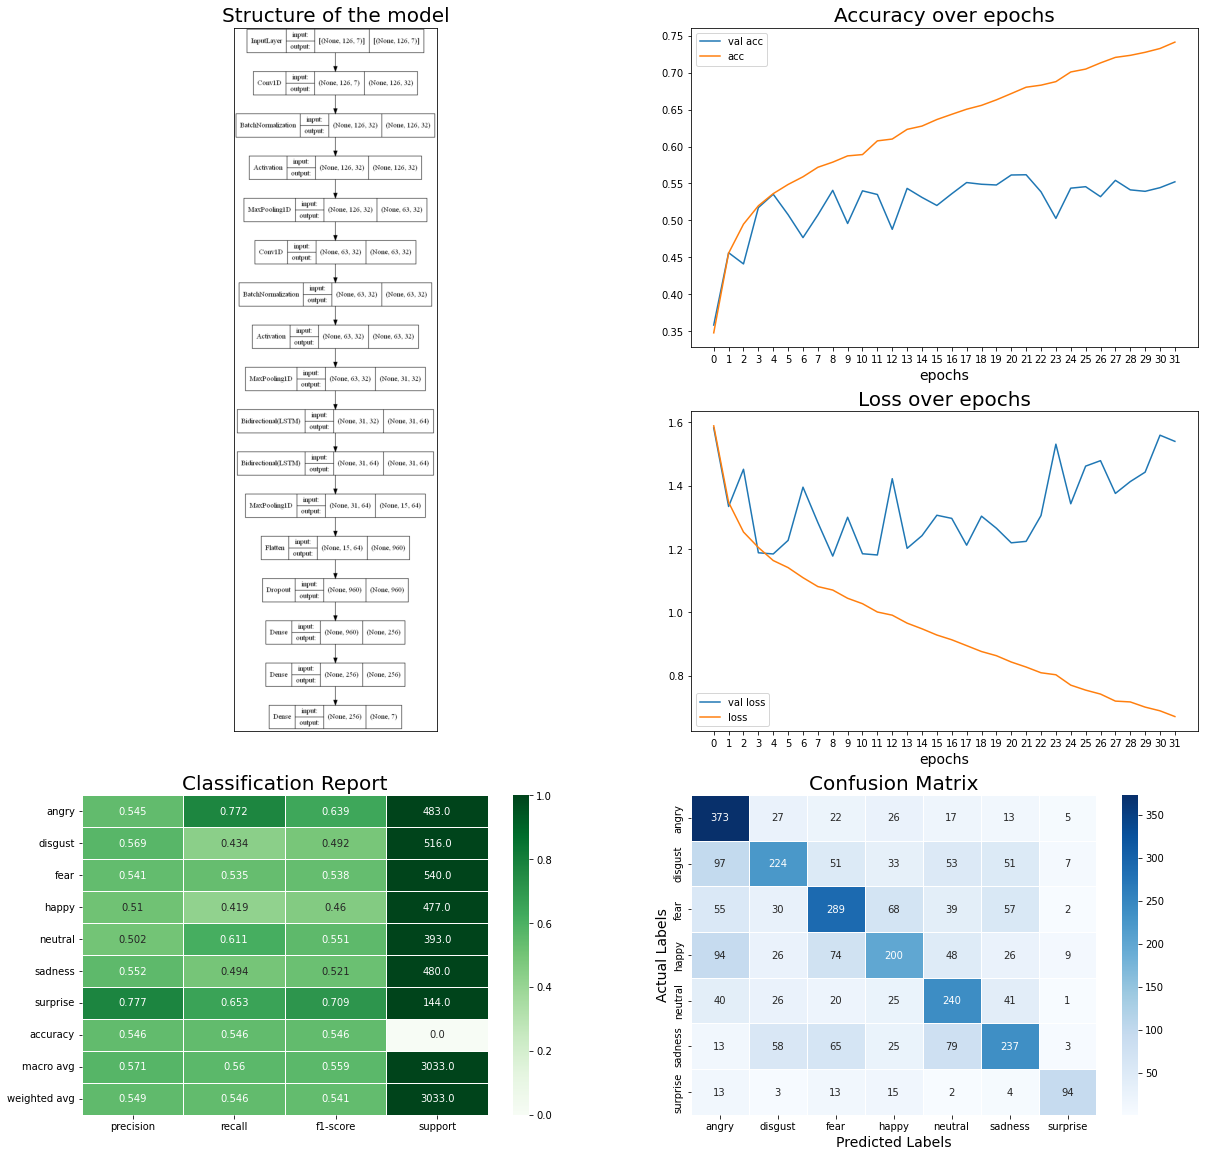



-----------------END-----------------




In [ ]:
for feature in ['sg', 'mf', 'cg', 'tn', 'sc']:
    print('\n\n-----------------'+feature.upper()+'-----------------\n\n')
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(feature)
    input_shape = X_train.shape[1:]

    model = get_lstm_model(input_shape)
    model.summary()

    compile_and_train(model, X_train, y_train, X_val, y_val, X_test, y_test, 1e-3, 'models/big_r/lstm_'+feature, 'report/big_r/lstm_'+feature+'.png')
    print('\n\n-----------------END-----------------\n\n')


### Ensembling

In [ ]:
sg_model = tf.keras.models.load_model('models/big_r/lstm_sg')
sg_model = Sequential(sg_model.layers[:-1])

mf_model = tf.keras.models.load_model('models/big_r/lstm_mf')
mf_model = Sequential(mf_model.layers[:-1])

cg_model = tf.keras.models.load_model('models/big_r/lstm_cg')
cg_model = Sequential(cg_model.layers[:-1])

tn_model = tf.keras.models.load_model('models/big_r/lstm_tn')
tn_model = Sequential(tn_model.layers[:-1])

sc_model = tf.keras.models.load_model('models/big_r/lstm_sc')
sc_model = Sequential(sc_model.layers[:-1])


sg_model._name = 'sg_model'
mf_model._name = 'mf_model'
cg_model._name = 'cg_model'
tn_model._name = 'tn_model'
sc_model._name = 'sc_model'

In [ ]:
sg = np.load('big_features_r/sg.npy')
mf = np.load('big_features_r/mf.npy')
cg = np.load('big_features_r/cg.npy')
tn = np.load('big_features_r/tn.npy')
sc = np.load('big_features_r/sc.npy')

y = np.load('y.npy')
y = np.concatenate([y,y,y])

mask_train = np.load('mask_train.npy')
mask_val = np.load('mask_val.npy')
mask_test = np.load('mask_test.npy')

mask_train = np.concatenate([mask_train, mask_train + n_samples, mask_train + 2*n_samples])
mask_val = np.concatenate([mask_val, mask_val + n_samples, mask_val + 2*n_samples])
mask_test = np.concatenate([mask_test, mask_test + n_samples, mask_test + 2*n_samples])

sg_train, sg_val, sg_test = sg[mask_train], sg[mask_val], sg[mask_test]
mf_train, mf_val, mf_test = mf[mask_train], mf[mask_val], mf[mask_test]
cg_train, cg_val, cg_test = cg[mask_train], cg[mask_val], cg[mask_test]
tn_train, tn_val, tn_test = tn[mask_train], tn[mask_val], tn[mask_test]
sc_train, sc_val, sc_test = sc[mask_train], sc[mask_val], sc[mask_test]

y_train, y_val, y_test = y[mask_train], y[mask_val], y[mask_test]

sg_shape = sg[0].shape
mf_shape = mf[0].shape
cg_shape = cg[0].shape
tn_shape = tn[0].shape
sc_shape = sc[0].shape

print('(n train, n val, n test) = ', (mask_train.shape[0], mask_val.shape[0], mask_test.shape[0]))

(n train, n val, n test) =  (24261, 3033, 3033)


In [ ]:
sg_input = Input(shape = sg_shape)
mf_input = Input(shape = mf_shape)
cg_input = Input(shape = cg_shape)
tn_input = Input(shape = tn_shape)
sc_input = Input(shape = sc_shape)

sg_output = sg_model(sg_input)
sg_output = Dense(64, activation = 'swish')(sg_output)

mf_output = mf_model(mf_input)
mf_output = Dense(64, activation = 'swish')(mf_output)

cg_output = cg_model(cg_input)
cg_output = Dense(64, activation = 'swish')(cg_output)

tn_output = tn_model(tn_input)
tn_output = Dense(64, activation = 'swish')(tn_output)

sc_output = sc_model(sc_input)
sc_output = Dense(64, activation = 'swish')(sc_output)

x = add([sg_output, mf_output, cg_output, tn_output, sc_output])

output = Dense(7, activation = 'softmax')(x)

model = Model([sg_input, mf_input, cg_input, tn_input, sc_input], output)

for l in model.layers[:-7]:
    l.trainable = False

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 126, 64)]    0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 126, 20)]    0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 126, 12)]    0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 126, 6)]     0           []                               
                                                                                           

Epoch 1/40
759/759 [==============================] - ETA: 0s - loss: 0.3949 - categorical_accuracy: 0.8587INFO:tensorflow:Assets written to: models/big_r\huge_lstm\assets


INFO:tensorflow:Assets written to: models/big_r\huge_lstm\assets


759/759 [==============================] - 383s 435ms/step - loss: 0.3949 - categorical_accuracy: 0.8587 - val_loss: 1.1471 - val_categorical_accuracy: 0.6841
Epoch 2/40
759/759 [==============================] - ETA: 0s - loss: 0.2561 - categorical_accuracy: 0.9039INFO:tensorflow:Assets written to: models/big_r\huge_lstm\assets


INFO:tensorflow:Assets written to: models/big_r\huge_lstm\assets


759/759 [==============================] - 219s 286ms/step - loss: 0.2561 - categorical_accuracy: 0.9039 - val_loss: 1.2266 - val_categorical_accuracy: 0.6924
Epoch 3/40
759/759 [==============================] - 123s 161ms/step - loss: 0.2304 - categorical_accuracy: 0.9116 - val_loss: 1.3040 - val_categorical_accuracy: 0.6914
Epoch 4/40
759/759 [==============================] - ETA: 0s - loss: 0.2150 - categorical_accuracy: 0.9195INFO:tensorflow:Assets written to: models/big_r\huge_lstm\assets


INFO:tensorflow:Assets written to: models/big_r\huge_lstm\assets


759/759 [==============================] - 207s 273ms/step - loss: 0.2150 - categorical_accuracy: 0.9195 - val_loss: 1.3475 - val_categorical_accuracy: 0.6934
Epoch 5/40
759/759 [==============================] - 130s 171ms/step - loss: 0.2083 - categorical_accuracy: 0.9230 - val_loss: 1.3686 - val_categorical_accuracy: 0.6904
Epoch 6/40
759/759 [==============================] - ETA: 0s - loss: 0.1916 - categorical_accuracy: 0.9273INFO:tensorflow:Assets written to: models/big_r\huge_lstm\assets


INFO:tensorflow:Assets written to: models/big_r\huge_lstm\assets


759/759 [==============================] - 202s 266ms/step - loss: 0.1916 - categorical_accuracy: 0.9273 - val_loss: 1.4419 - val_categorical_accuracy: 0.6954
Epoch 7/40
759/759 [==============================] - 127s 168ms/step - loss: 0.1835 - categorical_accuracy: 0.9305 - val_loss: 1.4735 - val_categorical_accuracy: 0.6894
Epoch 8/40
759/759 [==============================] - 130s 171ms/step - loss: 0.1850 - categorical_accuracy: 0.9315 - val_loss: 1.4656 - val_categorical_accuracy: 0.6907
Epoch 9/40
759/759 [==============================] - 134s 176ms/step - loss: 0.1780 - categorical_accuracy: 0.9327 - val_loss: 1.4880 - val_categorical_accuracy: 0.6917
Epoch 10/40
759/759 [==============================] - ETA: 0s - loss: 0.1745 - categorical_accuracy: 0.9333INFO:tensorflow:Assets written to: models/big_r\huge_lstm\assets


INFO:tensorflow:Assets written to: models/big_r\huge_lstm\assets


759/759 [==============================] - 211s 279ms/step - loss: 0.1745 - categorical_accuracy: 0.9333 - val_loss: 1.5382 - val_categorical_accuracy: 0.6986
Epoch 11/40
759/759 [==============================] - 134s 177ms/step - loss: 0.1697 - categorical_accuracy: 0.9352 - val_loss: 1.5195 - val_categorical_accuracy: 0.6954
Epoch 12/40
759/759 [==============================] - 132s 174ms/step - loss: 0.1583 - categorical_accuracy: 0.9399 - val_loss: 1.6009 - val_categorical_accuracy: 0.6841
Epoch 13/40
759/759 [==============================] - 130s 171ms/step - loss: 0.1579 - categorical_accuracy: 0.9406 - val_loss: 1.5810 - val_categorical_accuracy: 0.6901
Epoch 14/40
759/759 [==============================] - 136s 179ms/step - loss: 0.1537 - categorical_accuracy: 0.9404 - val_loss: 1.6470 - val_categorical_accuracy: 0.6927
Epoch 15/40
759/759 [==============================] - 130s 172ms/step - loss: 0.1521 - categorical_accuracy: 0.9414 - val_loss: 1.7120 - val_categorical_acc

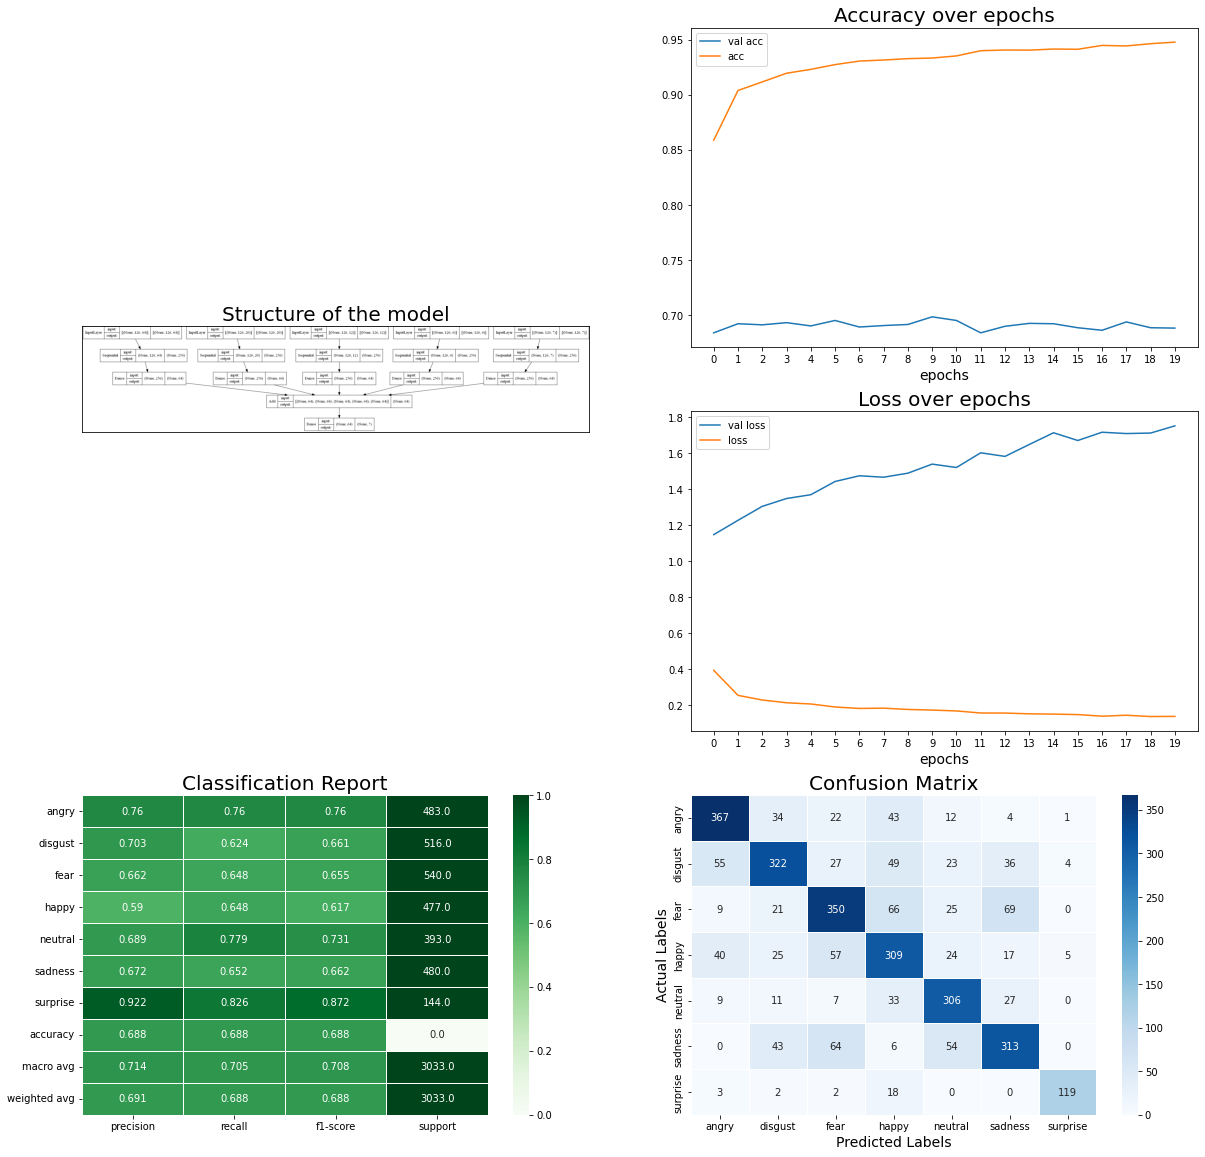

In [ ]:
X_train = [sg_train, mf_train, cg_train, tn_train, sc_train]
X_val = [sg_val, mf_val, cg_val, tn_val, sc_val]
X_test = [sg_test,mf_test,cg_test,tn_test,sc_test] 

compile_and_train(model, X_train, y_train, X_val, y_val, X_test, y_test, 1e-3, 'models/big_r/huge_lstm',  'report/big_r/huge_lstm.png')

# Importing other model's Features

Utility function to create the other models' features

In [ ]:
def get_data():
    X = np.load('very_big_features_r/sg.npy')
    X = X.reshape(X.shape + (1, ))

    y = np.load('y.npy')
    y = np.concatenate([y,y])


    mask_train = np.load('mask_train.npy')
    mask_val = np.load('mask_val.npy')
    mask_test = np.load('mask_test.npy')

    mask_train = np.concatenate([mask_train, mask_train + n_samples])
    mask_val = np.concatenate([mask_val, mask_val + n_samples])
    mask_test = np.concatenate([mask_test, mask_test + n_samples])

    X_train, X_val, X_test, y_train, y_val, y_test = X[mask_train], X[mask_val], X[mask_test], y[mask_train], y[mask_val], y[mask_test]

    X_test = X_test.reshape(X_test.shape + (1,))
    X_val = X_val.reshape(X_val.shape + (1, ))
    X_train = X_train.reshape(X_train.shape + (1, ))

    X_train = np.concatenate([X_train]*3, axis = 3)
    X_val = np.concatenate([X_val]*3, axis = 3)
    X_test = np.concatenate([X_test]*3, axis = 3)

    print('Shape of the feature = ', X[0].shape)
    print('(n train, n val, n test) = ', (mask_train.shape[0], mask_val.shape[0], mask_test.shape[0]))

    return X_train, X_val, X_test, y_train, y_val, y_test

# Transfer learning model with EfficientNetV2B0

I am going to build a model that is composed by the convolutional layers of EfficientNet and a stack of dense layers. During training the weights of EfficientNet are kept frozen.

### Creating and training the model

Importing the Efficient Net

In [ ]:
EfficientNet = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(251, 64, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
)

Getting data

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data()

Shape of the feature =  (251, 64, 1)
(n train, n val, n test) =  (16174, 2022, 2022)


To speed up the computations I compute the outputs of the efficient net once and feed the ouput to a small network.

In [ ]:
#X_train_1 = EfficientNet.predict(X_train)
X_val_1 = EfficientNet.predict(X_val)
X_test_1 = EfficientNet.predict(X_test)

In [ ]:
X_train_1 = np.zeros((X_train.shape[0],) + (8, 2, 1280))
X_val_1 = np.zeros((X_val.shape[0],) + (8, 2, 1280))
X_test_1 = np.zeros((X_test.shape[0],) + (8, 2, 1280))


X_train_1 = EfficientNet.predict(X_train)

X_val_1 = EfficientNet.predict(X_val)

X_test_1 = EfficientNet.predict(X_test)

Creating the top of the model.

In [ ]:
input = Input(shape = (8, 2, 1280))

x = Flatten()(input)
x = Dropout(0.3)(x)
x = Dense(512, activation = 'swish')(x)
x = Dense(256, activation = 'swish')(x)
x = Dense(256, activation = 'swish')(x)

output = Dense(7, activation = 'softmax')(x)

model = Model(input, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 2, 1280)]      0         
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dropout (Dropout)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 512)               10486272  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 7)                 1799  

Compiling and training.

Epoch 1/40
506/506 [==============================] - 25s 46ms/step - loss: 1.2287 - categorical_accuracy: 0.5242 - val_loss: 1.1704 - val_categorical_accuracy: 0.5480
Epoch 2/40
506/506 [==============================] - 23s 46ms/step - loss: 0.9863 - categorical_accuracy: 0.6136 - val_loss: 1.0509 - val_categorical_accuracy: 0.6004
Epoch 3/40
506/506 [==============================] - 20s 39ms/step - loss: 0.8891 - categorical_accuracy: 0.6606 - val_loss: 1.0582 - val_categorical_accuracy: 0.5861
Epoch 4/40
506/506 [==============================] - 23s 46ms/step - loss: 0.8343 - categorical_accuracy: 0.6802 - val_loss: 1.0464 - val_categorical_accuracy: 0.6014
Epoch 5/40
506/506 [==============================] - 23s 46ms/step - loss: 0.7603 - categorical_accuracy: 0.7083 - val_loss: 1.0848 - val_categorical_accuracy: 0.6029
Epoch 6/40
506/506 [==============================] - 23s 46ms/step - loss: 0.7100 - categorical_accuracy: 0.7317 - val_loss: 1.0494 - val_categorical_accuracy:

FileNotFoundError: [Errno 2] No such file or directory: 'report/very_big_r/effnet_sg.png'

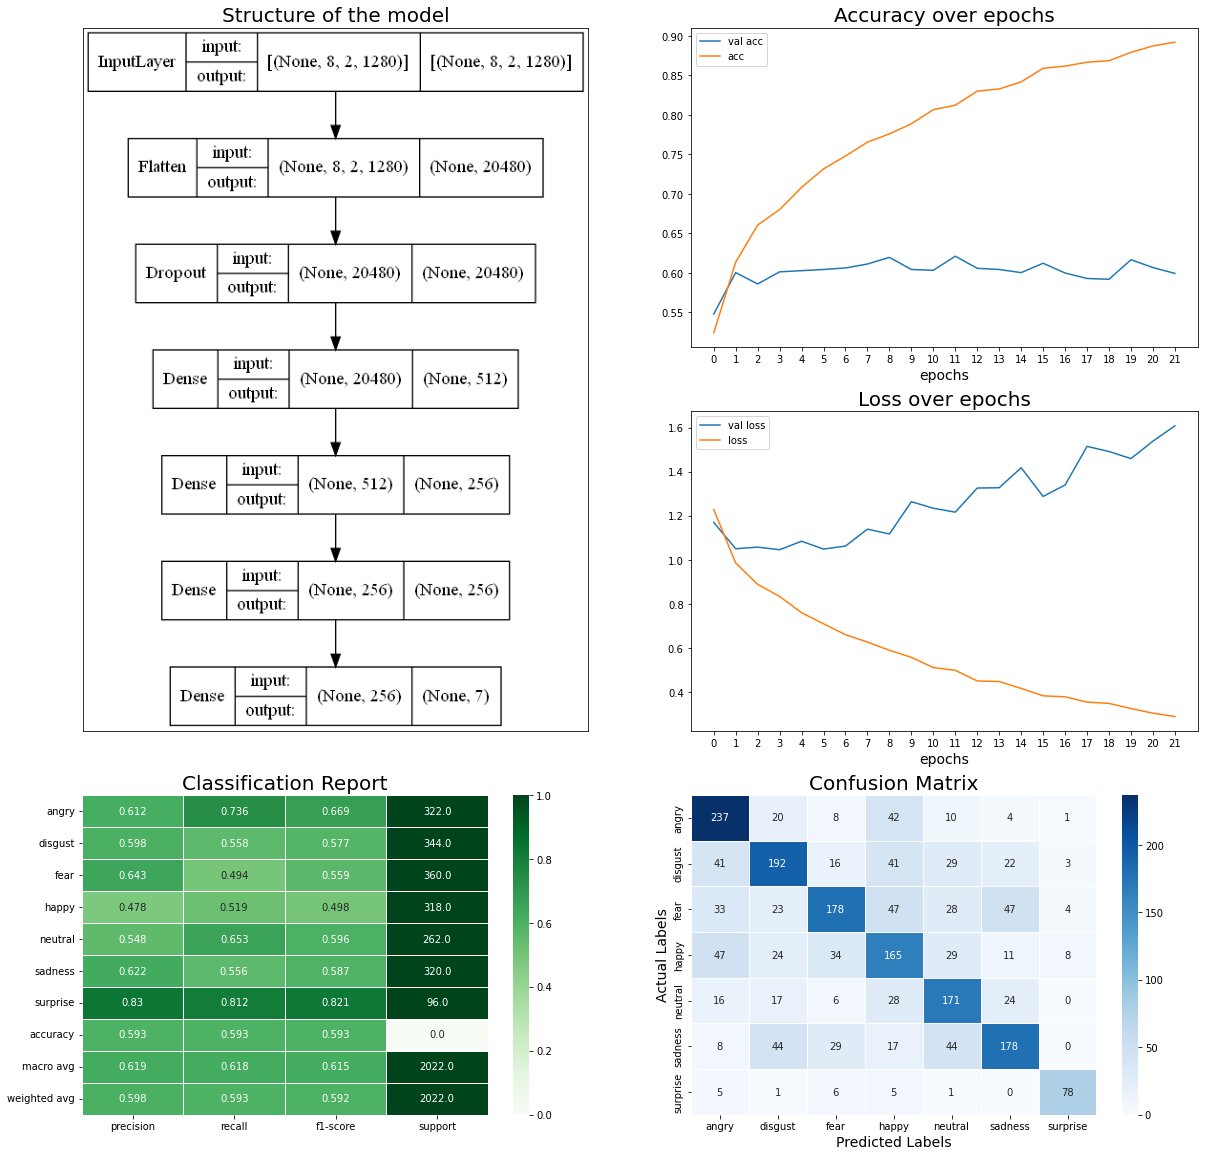

In [ ]:
compile_and_train(model, X_train_1, y_train, X_val_1, y_val, X_test_1, y_test, 1e-3, 'models/very_big_r/effnet_sg', 'report/very_big_r/effnet_sg.png')

# LSTM Model

The architecture is composed as follows:
- 3 1D convolutional layers, each followed by a Layernormalization layer, a swish activation function and a 1D MaxPooling layer;
- 2 Bidirectional LSTM layers, followed by a 1D MaxPooling layer;
- One flatten layer, followed by a Dropout layer;
- 2 Dense layer with 256 neurons each and swish as activation function
- the classification layer of dimension 7, with a softmax activation function

### Utils

Utility function that returns the model

In [ ]:
def get_lstm_model(input_shape):
    input = Input(shape = input_shape)

    x = Conv1D(32, 5, padding = 'same')(input)
    x = LayerNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPool1D(2)(x)

    x = Conv1D(32, 5, padding = 'same')(x)
    x = LayerNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPool1D(2)(x)

    x = Conv1D(32, 5, padding = 'same')(x)
    x = LayerNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPool1D(2)(x)

    x = Bidirectional(LSTM(64, return_sequences = True, dropout=0.3, recurrent_dropout = 0.3))(x)
    x = Bidirectional(LSTM(64, return_sequences = True, dropout=0.3, recurrent_dropout = 0.3))(x)
    x = MaxPool1D(2)(x)
    x = Flatten()(x)

    x = Dropout(0.4)(x)
    x = Dense(256, activation = 'swish')(x)
    x = Dense(256, activation = 'swish')(x)
    output = Dense(7, activation = 'softmax')(x)

    model = Model(input, output)
    return model  

### Compiling, training and evaluating

Shape of the feature =  (251, 64)
(n train, n val, n test) =  (16174, 2022, 2022)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 251, 64)]         0         
                                                                 
 conv1d_18 (Conv1D)          (None, 251, 32)           10272     
                                                                 
 layer_normalization_18 (Lay  (None, 251, 32)          64        
 erNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 251, 32)           0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 125, 32)          0         
 1D)                                                             
                                           

506/506 [==============================] - 67s 118ms/step - loss: 1.6267 - categorical_accuracy: 0.3318 - val_loss: 1.6151 - val_categorical_accuracy: 0.3358
Epoch 2/40
506/506 [==============================] - ETA: 0s - loss: 1.4056 - categorical_accuracy: 0.4241INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


506/506 [==============================] - 54s 106ms/step - loss: 1.4056 - categorical_accuracy: 0.4241 - val_loss: 1.3639 - val_categorical_accuracy: 0.4713
Epoch 3/40
506/506 [==============================] - ETA: 0s - loss: 1.2548 - categorical_accuracy: 0.4965INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


506/506 [==============================] - 56s 110ms/step - loss: 1.2548 - categorical_accuracy: 0.4965 - val_loss: 1.2679 - val_categorical_accuracy: 0.4985
Epoch 4/40
506/506 [==============================] - ETA: 0s - loss: 1.1807 - categorical_accuracy: 0.5326INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


506/506 [==============================] - 59s 116ms/step - loss: 1.1807 - categorical_accuracy: 0.5326 - val_loss: 1.1197 - val_categorical_accuracy: 0.5539
Epoch 5/40
506/506 [==============================] - 51s 100ms/step - loss: 1.1002 - categorical_accuracy: 0.5637 - val_loss: 1.1797 - val_categorical_accuracy: 0.5331
Epoch 6/40
506/506 [==============================] - ETA: 0s - loss: 1.0403 - categorical_accuracy: 0.5860INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


506/506 [==============================] - 63s 124ms/step - loss: 1.0403 - categorical_accuracy: 0.5860 - val_loss: 1.1178 - val_categorical_accuracy: 0.5579
Epoch 7/40
506/506 [==============================] - ETA: 0s - loss: 1.0109 - categorical_accuracy: 0.5983INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


506/506 [==============================] - 60s 119ms/step - loss: 1.0109 - categorical_accuracy: 0.5983 - val_loss: 1.0610 - val_categorical_accuracy: 0.5776
Epoch 8/40
506/506 [==============================] - ETA: 0s - loss: 0.9683 - categorical_accuracy: 0.6190INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


506/506 [==============================] - 60s 118ms/step - loss: 0.9683 - categorical_accuracy: 0.6190 - val_loss: 1.0467 - val_categorical_accuracy: 0.5984
Epoch 9/40
506/506 [==============================] - ETA: 0s - loss: 0.9367 - categorical_accuracy: 0.6385INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


506/506 [==============================] - 62s 123ms/step - loss: 0.9367 - categorical_accuracy: 0.6385 - val_loss: 1.0136 - val_categorical_accuracy: 0.6147
Epoch 10/40
506/506 [==============================] - 53s 105ms/step - loss: 0.9021 - categorical_accuracy: 0.6501 - val_loss: 1.1054 - val_categorical_accuracy: 0.5900
Epoch 11/40
506/506 [==============================] - 55s 109ms/step - loss: 0.8703 - categorical_accuracy: 0.6621 - val_loss: 1.0519 - val_categorical_accuracy: 0.6063
Epoch 12/40
506/506 [==============================] - ETA: 0s - loss: 0.8489 - categorical_accuracy: 0.6664INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


506/506 [==============================] - 66s 131ms/step - loss: 0.8489 - categorical_accuracy: 0.6664 - val_loss: 1.0070 - val_categorical_accuracy: 0.6261
Epoch 13/40
506/506 [==============================] - 54s 107ms/step - loss: 0.8016 - categorical_accuracy: 0.6864 - val_loss: 1.0103 - val_categorical_accuracy: 0.6251
Epoch 14/40
506/506 [==============================] - 54s 107ms/step - loss: 0.7795 - categorical_accuracy: 0.6983 - val_loss: 0.9806 - val_categorical_accuracy: 0.6251
Epoch 15/40
506/506 [==============================] - 53s 104ms/step - loss: 0.7469 - categorical_accuracy: 0.7090 - val_loss: 1.0672 - val_categorical_accuracy: 0.6048
Epoch 16/40
506/506 [==============================] - 53s 105ms/step - loss: 0.7121 - categorical_accuracy: 0.7214 - val_loss: 1.0302 - val_categorical_accuracy: 0.6217
Epoch 17/40
506/506 [==============================] - ETA: 0s - loss: 0.6756 - categorical_accuracy: 0.7337INFO:tensorflow:Assets written to: models/big_r\lstm_s

INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


506/506 [==============================] - 66s 130ms/step - loss: 0.6756 - categorical_accuracy: 0.7337 - val_loss: 1.0979 - val_categorical_accuracy: 0.6271
Epoch 18/40
506/506 [==============================] - 56s 111ms/step - loss: 0.6471 - categorical_accuracy: 0.7490 - val_loss: 1.1001 - val_categorical_accuracy: 0.6192
Epoch 19/40
506/506 [==============================] - 57s 113ms/step - loss: 0.6205 - categorical_accuracy: 0.7607 - val_loss: 1.1125 - val_categorical_accuracy: 0.6227
Epoch 20/40
506/506 [==============================] - ETA: 0s - loss: 0.5877 - categorical_accuracy: 0.7713INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_sg\assets


506/506 [==============================] - 68s 135ms/step - loss: 0.5877 - categorical_accuracy: 0.7713 - val_loss: 1.0787 - val_categorical_accuracy: 0.6345
Epoch 21/40
506/506 [==============================] - 66s 131ms/step - loss: 0.5607 - categorical_accuracy: 0.7824 - val_loss: 1.1204 - val_categorical_accuracy: 0.6108
Epoch 22/40
506/506 [==============================] - 66s 131ms/step - loss: 0.5349 - categorical_accuracy: 0.7934 - val_loss: 1.2058 - val_categorical_accuracy: 0.6182
Epoch 23/40
506/506 [==============================] - 66s 131ms/step - loss: 0.5089 - categorical_accuracy: 0.8007 - val_loss: 1.3343 - val_categorical_accuracy: 0.6187
Epoch 24/40
506/506 [==============================] - 66s 130ms/step - loss: 0.4751 - categorical_accuracy: 0.8180 - val_loss: 1.2911 - val_categorical_accuracy: 0.6182
Epoch 25/40
506/506 [==============================] - 67s 133ms/step - loss: 0.4561 - categorical_accuracy: 0.8268 - val_loss: 1.2686 - val_categorical_accuracy:

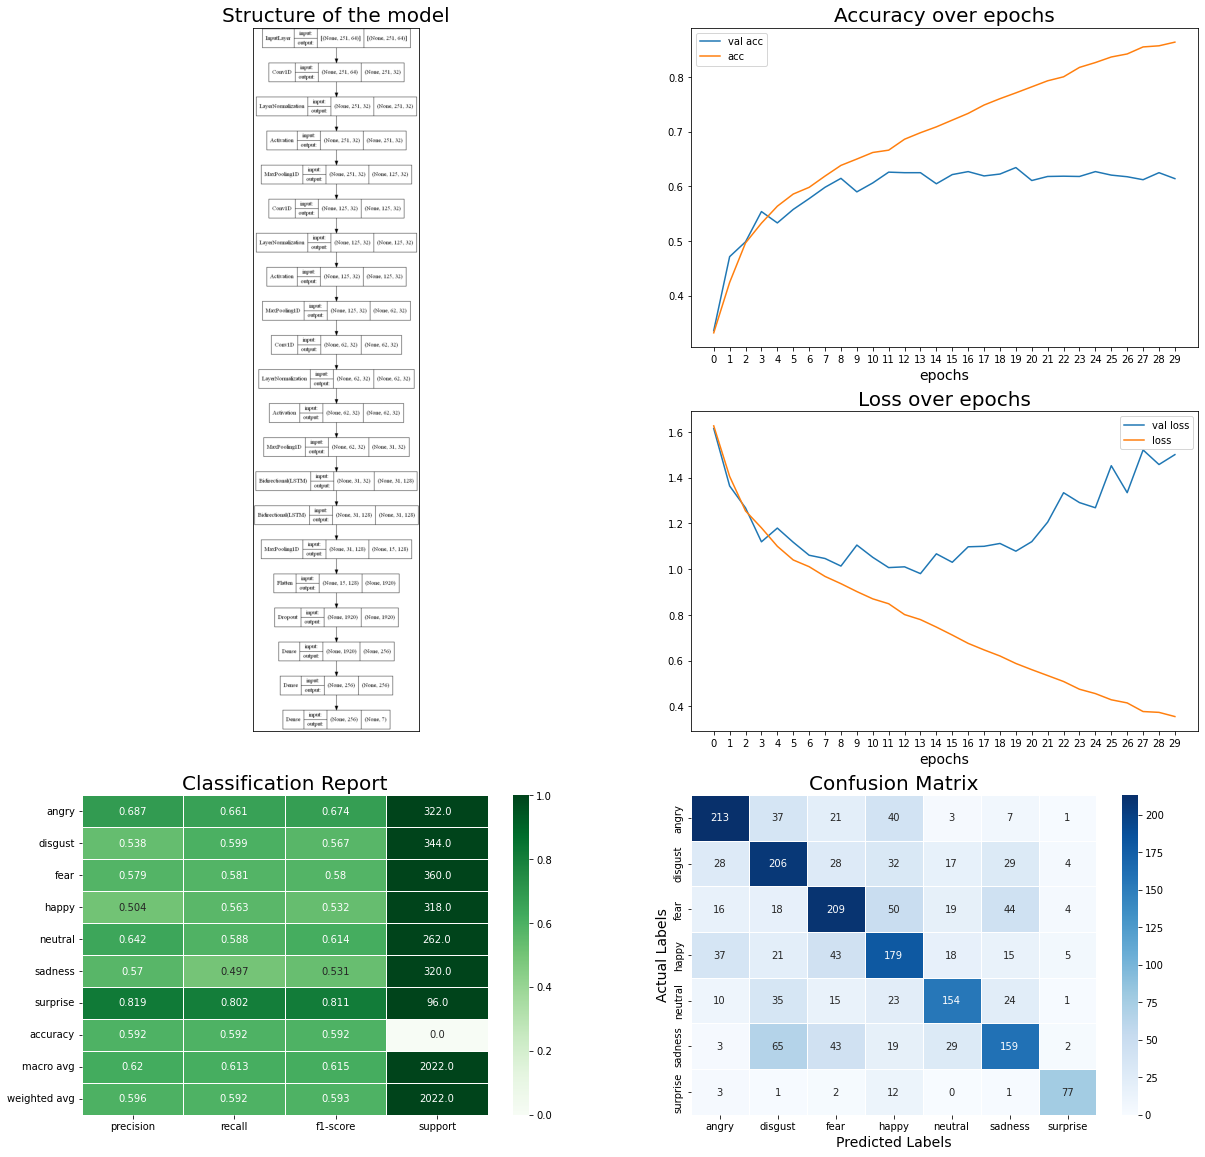

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data('sg')
model = get_lstm_model(X_train.shape[1:])

model.summary()

compile_and_train(model, X_train, y_train, X_val, y_val, X_test, y_test, 1e-3, 'models/big_r/lstm_sg',  'report/big_r/lstm_sg.png')

# Conv2D Model

I am going to create a model that takes as input the mel sale spectrograms with a window size of the fft of 512, that corresponds to 0.032s, and a number of samples between successive frames of 256.

In this way the spectrograms have 251 time steps.

The architecture is composed as follows:
- 3 2D convolutional blocks, each composed by 2 convolutional layers with kernel size 3x3, followed by BatchNormalization, swish activation and a 2D MaxPooling. The number of channles is doubled after each block
- 1 2D convolutional block with one 2D convolutional layer of 32 channels, to reduce the feature dimension, followed by a BatchNormalization layer, a swish activation and a 2D MaxPooling.
- 1 Flatten layer followed by a dropout layer to regularize the model and avoid severe overfitting
- 2 dense layer of 256 neurons each, with swish as activation function
- the classification layer of dimension 7, with softmaz as activation function

### Utils

In [ ]:
def get_conv_model(input_shape):
    input = Input(shape =  input_shape + (1, ) )

    x = Conv2D(filters = 64, kernel_size=3, strides=1, padding='same')(input)
    x = Conv2D(filters = 64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

    x = Conv2D(filters = 128, kernel_size=3, strides=1, padding='same')(x)
    x = Conv2D(filters = 128, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

    x = Conv2D(filters = 256, kernel_size=3, strides=1, padding='same')(x)
    x = Conv2D(filters = 256, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

    x = Conv2D(filters = 32, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation = 'swish')(x)
    x = Dense(256, activation = 'swish')(x)
    x = Dense(7, activation = 'softmax')(x)

    model = Model(inputs = input, outputs=x)

    return model

### Train

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data('sg')
model = get_conv_model(X_train.shape[1:])
model.summary()

compile_and_train(model, X_train, y_train, X_val, y_val, X_test, y_test, 1e-3, 'models/big_r/conv_sg',  'report/big_r/conv_sg.png')

Shape of the feature =  (251, 64)
(n train, n val, n test) =  (16174, 2022, 2022)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 251, 64, 1)]      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 251, 64, 64)       640       
                                                                 
 conv2d_15 (Conv2D)          (None, 251, 64, 64)       36928     
                                                                 
 batch_normalization_8 (Batc  (None, 251, 64, 64)      256       
 hNormalization)                                                 
                                                                 
 activation_17 (Activation)  (None, 251, 64, 64)       0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 126, 3

INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


506/506 [==============================] - 1752s 3s/step - loss: 1.3912 - categorical_accuracy: 0.4432 - val_loss: 1.2633 - val_categorical_accuracy: 0.5302
Epoch 2/40
506/506 [==============================] - ETA: 0s - loss: 1.0933 - categorical_accuracy: 0.5712INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


506/506 [==============================] - 1817s 4s/step - loss: 1.0933 - categorical_accuracy: 0.5712 - val_loss: 1.0964 - val_categorical_accuracy: 0.5697
Epoch 3/40
506/506 [==============================] - 1910s 4s/step - loss: 1.0074 - categorical_accuracy: 0.6062 - val_loss: 1.1330 - val_categorical_accuracy: 0.5589
Epoch 4/40
506/506 [==============================] - 1928s 4s/step - loss: 0.9381 - categorical_accuracy: 0.6381 - val_loss: 1.3592 - val_categorical_accuracy: 0.5341
Epoch 5/40
506/506 [==============================] - ETA: 0s - loss: 0.8855 - categorical_accuracy: 0.6557INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


506/506 [==============================] - 1963s 4s/step - loss: 0.8855 - categorical_accuracy: 0.6557 - val_loss: 1.0561 - val_categorical_accuracy: 0.5974
Epoch 6/40
506/506 [==============================] - 1846s 4s/step - loss: 0.8272 - categorical_accuracy: 0.6814 - val_loss: 1.2910 - val_categorical_accuracy: 0.5460
Epoch 7/40
506/506 [==============================] - ETA: 0s - loss: 0.7791 - categorical_accuracy: 0.6962INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


506/506 [==============================] - 1788s 4s/step - loss: 0.7791 - categorical_accuracy: 0.6962 - val_loss: 0.9996 - val_categorical_accuracy: 0.6335
Epoch 8/40
506/506 [==============================] - 1986s 4s/step - loss: 0.7198 - categorical_accuracy: 0.7218 - val_loss: 1.0048 - val_categorical_accuracy: 0.6108
Epoch 9/40
506/506 [==============================] - ETA: 0s - loss: 0.6664 - categorical_accuracy: 0.7475INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


506/506 [==============================] - 1973s 4s/step - loss: 0.6664 - categorical_accuracy: 0.7475 - val_loss: 1.0050 - val_categorical_accuracy: 0.6350
Epoch 10/40
506/506 [==============================] - 1985s 4s/step - loss: 0.6057 - categorical_accuracy: 0.7699 - val_loss: 1.0829 - val_categorical_accuracy: 0.6152
Epoch 11/40
506/506 [==============================] - 1998s 4s/step - loss: 0.5540 - categorical_accuracy: 0.7903 - val_loss: 1.1363 - val_categorical_accuracy: 0.6217
Epoch 12/40
506/506 [==============================] - 1961s 4s/step - loss: 0.5152 - categorical_accuracy: 0.8062 - val_loss: 1.0693 - val_categorical_accuracy: 0.6320
Epoch 13/40
506/506 [==============================] - 1951s 4s/step - loss: 0.4638 - categorical_accuracy: 0.8288 - val_loss: 1.1578 - val_categorical_accuracy: 0.6236
Epoch 14/40
506/506 [==============================] - 1944s 4s/step - loss: 0.4172 - categorical_accuracy: 0.8444 - val_loss: 1.1469 - val_categorical_accuracy: 0.630

INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


506/506 [==============================] - 1953s 4s/step - loss: 0.3486 - categorical_accuracy: 0.8687 - val_loss: 1.2523 - val_categorical_accuracy: 0.6370
Epoch 17/40
506/506 [==============================] - ETA: 0s - loss: 0.3294 - categorical_accuracy: 0.8766INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


506/506 [==============================] - 1945s 4s/step - loss: 0.3294 - categorical_accuracy: 0.8766 - val_loss: 1.2380 - val_categorical_accuracy: 0.6419
Epoch 18/40
506/506 [==============================] - 1947s 4s/step - loss: 0.2933 - categorical_accuracy: 0.8956 - val_loss: 1.2850 - val_categorical_accuracy: 0.6301
Epoch 19/40
506/506 [==============================] - ETA: 0s - loss: 0.2718 - categorical_accuracy: 0.8996INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


506/506 [==============================] - 1941s 4s/step - loss: 0.2718 - categorical_accuracy: 0.8996 - val_loss: 1.3103 - val_categorical_accuracy: 0.6518
Epoch 20/40
506/506 [==============================] - 1923s 4s/step - loss: 0.2606 - categorical_accuracy: 0.9047 - val_loss: 1.3172 - val_categorical_accuracy: 0.6424
Epoch 21/40
506/506 [==============================] - 1916s 4s/step - loss: 0.2270 - categorical_accuracy: 0.9172 - val_loss: 1.5275 - val_categorical_accuracy: 0.6340
Epoch 22/40
506/506 [==============================] - 1933s 4s/step - loss: 0.2166 - categorical_accuracy: 0.9223 - val_loss: 1.3935 - val_categorical_accuracy: 0.6419
Epoch 23/40
506/506 [==============================] - 1927s 4s/step - loss: 0.1990 - categorical_accuracy: 0.9273 - val_loss: 1.6138 - val_categorical_accuracy: 0.6330
Epoch 24/40
506/506 [==============================] - 1935s 4s/step - loss: 0.2039 - categorical_accuracy: 0.9267 - val_loss: 1.5364 - val_categorical_accuracy: 0.625

INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


506/506 [==============================] - 1924s 4s/step - loss: 0.1886 - categorical_accuracy: 0.9306 - val_loss: 1.4120 - val_categorical_accuracy: 0.6563
Epoch 26/40
506/506 [==============================] - 3049s 6s/step - loss: 0.1834 - categorical_accuracy: 0.9340 - val_loss: 1.5869 - val_categorical_accuracy: 0.6400
Epoch 27/40
506/506 [==============================] - 3058s 6s/step - loss: 0.1664 - categorical_accuracy: 0.9408 - val_loss: 1.5201 - val_categorical_accuracy: 0.6390
Epoch 28/40
506/506 [==============================] - 3082s 6s/step - loss: 0.1579 - categorical_accuracy: 0.9436 - val_loss: 1.6075 - val_categorical_accuracy: 0.6523
Epoch 29/40
506/506 [==============================] - 3064s 6s/step - loss: 0.1548 - categorical_accuracy: 0.9453 - val_loss: 1.5931 - val_categorical_accuracy: 0.6395
Epoch 30/40
506/506 [==============================] - 3052s 6s/step - loss: 0.1526 - categorical_accuracy: 0.9470 - val_loss: 1.5258 - val_categorical_accuracy: 0.642

INFO:tensorflow:Assets written to: models/big_r\conv_sg\assets


506/506 [==============================] - 3187s 6s/step - loss: 0.1443 - categorical_accuracy: 0.9494 - val_loss: 1.5461 - val_categorical_accuracy: 0.6657
Epoch 32/40
506/506 [==============================] - 3051s 6s/step - loss: 0.1350 - categorical_accuracy: 0.9516 - val_loss: 1.7123 - val_categorical_accuracy: 0.6375
Epoch 33/40
506/506 [==============================] - 3052s 6s/step - loss: 0.1363 - categorical_accuracy: 0.9525 - val_loss: 1.7386 - val_categorical_accuracy: 0.6429
Epoch 34/40
506/506 [==============================] - 3052s 6s/step - loss: 0.1405 - categorical_accuracy: 0.9505 - val_loss: 1.6644 - val_categorical_accuracy: 0.6484
Epoch 35/40
506/506 [==============================] - 3062s 6s/step - loss: 0.1270 - categorical_accuracy: 0.9554 - val_loss: 1.6816 - val_categorical_accuracy: 0.6518
Epoch 36/40
506/506 [==============================] - 3076s 6s/step - loss: 0.1354 - categorical_accuracy: 0.9523 - val_loss: 1.8104 - val_categorical_accuracy: 0.633

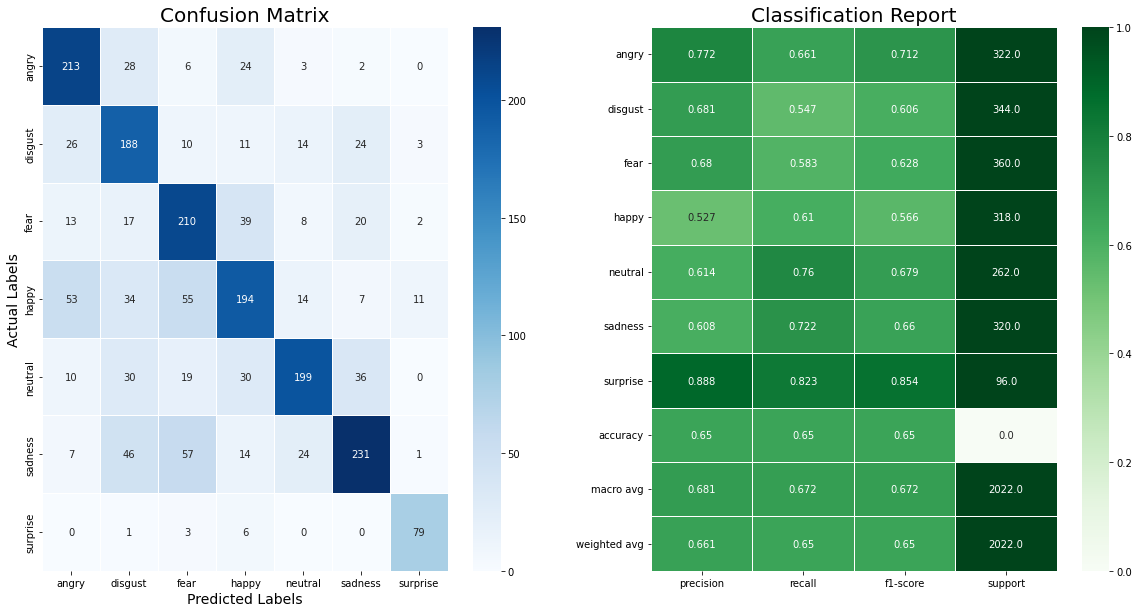

In [ ]:
c_report(model, X_test, y_test)

# LSTM - Conv2D Model

Each spectrogram could be considered as a one channel image and as a time-series. Indeed both the convolutional and the recurrent model turned to be effective.

To merge the power of the two models I have tried to merge them.

The ensemble model is composed by the two models describe in the last two sections. From each model I have removed the last layer and I have stacked to each mdoel a Dense layer with 64 neurons and activation swish. I have then added the two outputs and completed the model with the usual classification layer.

In order to train only the last Dense layers, I have freezed the two pretrained models' weights.

In [ ]:
lstm_model = tf.keras.models.load_model('models/big_r/lstm_sg')
lstm_model = Sequential(lstm_model.layers[:-1])

conv_model = tf.keras.models.load_model('models/big_r/conv_sg')
conv_model = Sequential(conv_model.layers[:-1])

In [ ]:
input = Input(shape = (251, 64))

lstm_output = lstm_model(input)
lstm_output = Dense(64, activation = 'swish')(lstm_output)

conv_output = conv_model(input)
conv_output = Dense(64, activation = 'swish')(conv_output)

x = add([lstm_output, conv_output])
output = Dense(7, activation = 'softmax')(x)

model = Model(input, output)
model.layers[1].trainable = False
model.layers[2].trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 251, 64)]    0           []                               
                                                                                                  
 sequential (Sequential)        (None, 256)          726816      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 256)          1744736     ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 64)           16448       ['sequential[0][0]']             
                                                                                              

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data('sg')

compile_and_train(model, X_train, y_train, X_val, y_val, X_test, y_test, 1e-3, 'models/big_r/lstm_conv_sg',  'report/big_r/lstm_conv_sg.png')

Shape of the feature =  (251, 64)
(n train, n val, n test) =  (16174, 2022, 2022)
Epoch 1/40
506/506 [==============================] - ETA: 0s - loss: 0.2270 - categorical_accuracy: 0.9267INFO:tensorflow:Assets written to: models/big_r\lstm_conv_sg\assets


506/506 [==============================] - 534s 1s/step - loss: 0.2270 - categorical_accuracy: 0.9267 - val_loss: 1.4247 - val_categorical_accuracy: 0.6706
Epoch 2/40
506/506 [==============================] - ETA: 0s - loss: 0.0817 - categorical_accuracy: 0.9721INFO:tensorflow:Assets written to: models/big_r\lstm_conv_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_conv_sg\assets


506/506 [==============================] - 501s 991ms/step - loss: 0.0817 - categorical_accuracy: 0.9721 - val_loss: 1.6487 - val_categorical_accuracy: 0.6716
Epoch 3/40
506/506 [==============================] - ETA: 0s - loss: 0.0792 - categorical_accuracy: 0.9724INFO:tensorflow:Assets written to: models/big_r\lstm_conv_sg\assets


INFO:tensorflow:Assets written to: models/big_r\lstm_conv_sg\assets


506/506 [==============================] - 552s 1s/step - loss: 0.0792 - categorical_accuracy: 0.9724 - val_loss: 1.7260 - val_categorical_accuracy: 0.6825
Epoch 4/40
506/506 [==============================] - 564s 1s/step - loss: 0.0730 - categorical_accuracy: 0.9747 - val_loss: 1.7737 - val_categorical_accuracy: 0.6795
Epoch 5/40
506/506 [==============================] - 580s 1s/step - loss: 0.0685 - categorical_accuracy: 0.9746 - val_loss: 1.8850 - val_categorical_accuracy: 0.6696
Epoch 6/40
506/506 [==============================] - 631s 1s/step - loss: 0.0673 - categorical_accuracy: 0.9766 - val_loss: 1.9096 - val_categorical_accuracy: 0.6691
Epoch 7/40
506/506 [==============================] - 639s 1s/step - loss: 0.0653 - categorical_accuracy: 0.9773 - val_loss: 1.8980 - val_categorical_accuracy: 0.6686
Epoch 8/40
506/506 [==============================] - 633s 1s/step - loss: 0.0669 - categorical_accuracy: 0.9761 - val_loss: 1.9528 - val_categorical_accuracy: 0.6691
Epoch 9/4

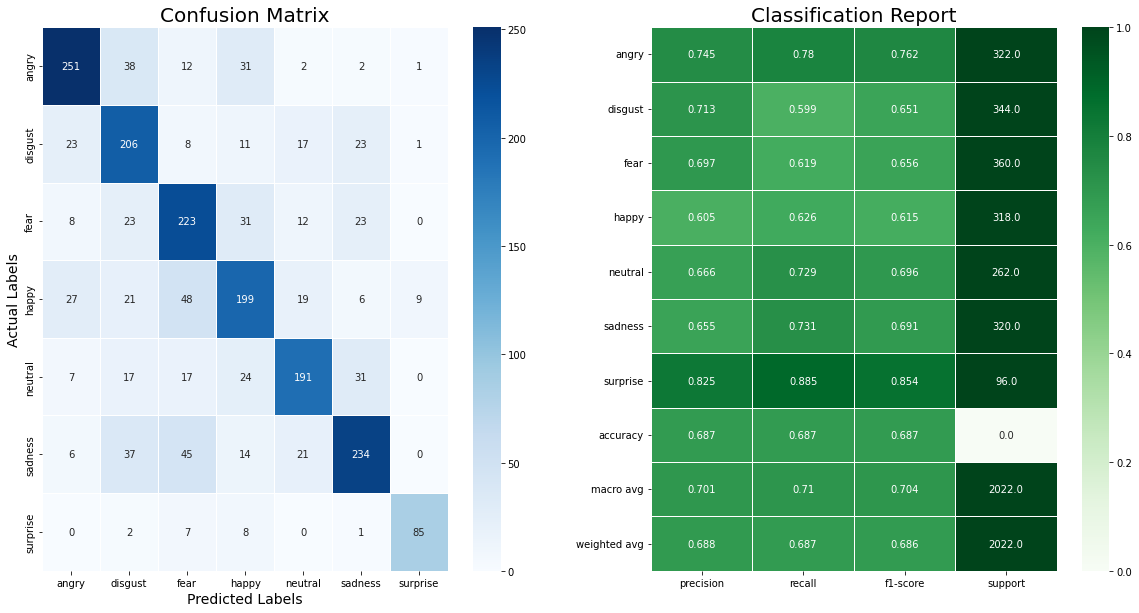

In [ ]:
c_report(model,X_test, y_test)

# Trasformer Model

### Utils

Defining some utility functions to create the create the trasformer model

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

# function that returns the positional encoding for the Mel Spectrograms
# as the trasformer model doesn't exploit the positional informations by itself
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


# function that returns the trasformer encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout = 0):
    x = LayerNormalization(epsilon = 1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size , num_heads=num_heads, dropout=dropout)(x, x, x)
    x = Dropout(dropout)(x)
    res = add([inputs, x])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return add([x, res])

# function to build the model
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = add([inputs, positional_encoding(251, 64)])
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format = 'channels_first')(x)
    for  dim in mlp_units:
        x = Dense(dim, activation = 'relu')(x)
        x = Dropout(mlp_dropout)(x)

    outputs = Dense(7, activation='softmax')(x)
    return Model(inputs, outputs)

### Creating and training the model

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data('sg')

model = build_model(
    X_train.shape[1:], 
    head_size = 256,
    num_heads = 6,
    ff_dim = 16,
    num_transformer_blocks=1,
    mlp_units=[256, 256],
    mlp_dropout=0.4,
    dropout=0.25)

model.summary()

Shape of the feature =  (251, 64)
(n train, n val, n test) =  (16174, 2022, 2022)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 251, 64)]    0           []                               
                                                                                                  
 add (Add)                      (None, 251, 64)      0           ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 251, 64)     128         ['add[0][0]']                    
 alization)                                                                                       
                                                                                                  
 multi_head_

Epoch 1/40
506/506 [==============================] - ETA: 0s - loss: 1.7050 - categorical_accuracy: 0.2839

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 401s 791ms/step - loss: 1.7050 - categorical_accuracy: 0.2839 - val_loss: 1.5028 - val_categorical_accuracy: 0.4120
Epoch 2/40
506/506 [==============================] - ETA: 0s - loss: 1.4376 - categorical_accuracy: 0.4254

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 401s 794ms/step - loss: 1.4376 - categorical_accuracy: 0.4254 - val_loss: 1.3808 - val_categorical_accuracy: 0.4792
Epoch 3/40
506/506 [==============================] - ETA: 0s - loss: 1.2562 - categorical_accuracy: 0.5076

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 411s 812ms/step - loss: 1.2562 - categorical_accuracy: 0.5076 - val_loss: 1.2844 - val_categorical_accuracy: 0.4847
Epoch 4/40
506/506 [==============================] - ETA: 0s - loss: 1.1948 - categorical_accuracy: 0.5373

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 420s 831ms/step - loss: 1.1948 - categorical_accuracy: 0.5373 - val_loss: 1.1791 - val_categorical_accuracy: 0.5504
Epoch 5/40
506/506 [==============================] - 412s 814ms/step - loss: 1.1445 - categorical_accuracy: 0.5506 - val_loss: 1.1578 - val_categorical_accuracy: 0.5485
Epoch 6/40
506/506 [==============================] - 413s 817ms/step - loss: 1.1234 - categorical_accuracy: 0.5591 - val_loss: 1.1601 - val_categorical_accuracy: 0.5485
Epoch 7/40
506/506 [==============================] - ETA: 0s - loss: 1.0894 - categorical_accuracy: 0.5762

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 417s 824ms/step - loss: 1.0894 - categorical_accuracy: 0.5762 - val_loss: 1.1394 - val_categorical_accuracy: 0.5663
Epoch 8/40
506/506 [==============================] - 422s 834ms/step - loss: 1.0725 - categorical_accuracy: 0.5775 - val_loss: 1.1651 - val_categorical_accuracy: 0.5396
Epoch 9/40
506/506 [==============================] - 419s 828ms/step - loss: 1.0541 - categorical_accuracy: 0.5911 - val_loss: 1.1486 - val_categorical_accuracy: 0.5549
Epoch 10/40
506/506 [==============================] - ETA: 0s - loss: 1.0313 - categorical_accuracy: 0.5999

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 418s 826ms/step - loss: 1.0313 - categorical_accuracy: 0.5999 - val_loss: 1.1151 - val_categorical_accuracy: 0.5811
Epoch 11/40
506/506 [==============================] - 412s 814ms/step - loss: 1.0250 - categorical_accuracy: 0.6016 - val_loss: 1.1371 - val_categorical_accuracy: 0.5554
Epoch 12/40
506/506 [==============================] - 416s 822ms/step - loss: 1.0026 - categorical_accuracy: 0.6112 - val_loss: 1.1352 - val_categorical_accuracy: 0.5589
Epoch 13/40
506/506 [==============================] - 421s 832ms/step - loss: 0.9934 - categorical_accuracy: 0.6154 - val_loss: 1.0894 - val_categorical_accuracy: 0.5781
Epoch 14/40
506/506 [==============================] - 410s 811ms/step - loss: 0.9698 - categorical_accuracy: 0.6219 - val_loss: 1.1175 - val_categorical_accuracy: 0.5603
Epoch 15/40
506/506 [==============================] - 408s 807ms/step - loss: 0.9794 - categorical_accuracy: 0.6196 - val_loss: 1.1403 - val_categorical_acc

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 409s 809ms/step - loss: 0.9216 - categorical_accuracy: 0.6452 - val_loss: 1.1065 - val_categorical_accuracy: 0.5846
Epoch 21/40
506/506 [==============================] - 406s 803ms/step - loss: 0.8988 - categorical_accuracy: 0.6489 - val_loss: 1.1385 - val_categorical_accuracy: 0.5529
Epoch 22/40
506/506 [==============================] - 408s 806ms/step - loss: 0.9015 - categorical_accuracy: 0.6553 - val_loss: 1.1227 - val_categorical_accuracy: 0.5757
Epoch 23/40
506/506 [==============================] - ETA: 0s - loss: 0.8928 - categorical_accuracy: 0.6538

INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


INFO:tensorflow:Assets written to: models/very_big\small_trasformer_sg\assets


506/506 [==============================] - 416s 822ms/step - loss: 0.8928 - categorical_accuracy: 0.6538 - val_loss: 1.1319 - val_categorical_accuracy: 0.5910
Epoch 24/40
506/506 [==============================] - 413s 817ms/step - loss: 0.8769 - categorical_accuracy: 0.6608 - val_loss: 1.1711 - val_categorical_accuracy: 0.5747
Epoch 25/40
506/506 [==============================] - 413s 817ms/step - loss: 0.8670 - categorical_accuracy: 0.6627 - val_loss: 1.1781 - val_categorical_accuracy: 0.5816
Epoch 26/40
506/506 [==============================] - 408s 807ms/step - loss: 0.8715 - categorical_accuracy: 0.6588 - val_loss: 1.1887 - val_categorical_accuracy: 0.5504
Epoch 27/40
506/506 [==============================] - 405s 801ms/step - loss: 0.8509 - categorical_accuracy: 0.6724 - val_loss: 1.1640 - val_categorical_accuracy: 0.5732
Epoch 28/40
506/506 [==============================] - 406s 802ms/step - loss: 0.8570 - categorical_accuracy: 0.6713 - val_loss: 1.1237 - val_categorical_acc

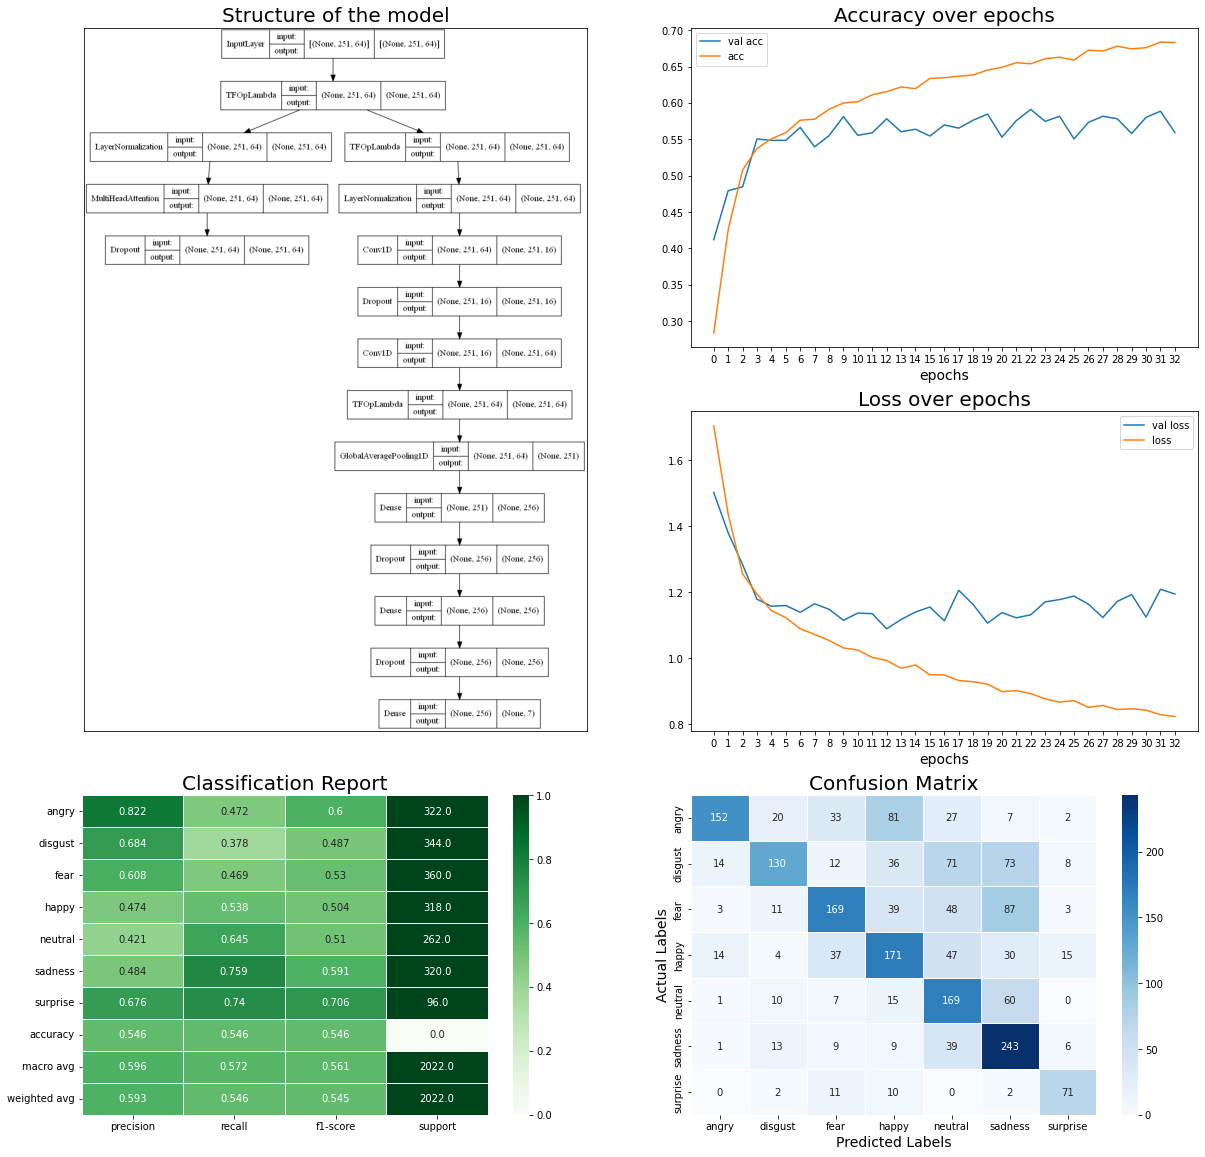

In [ ]:
compile_and_train(model, X_train, y_train, X_val, y_val, X_test, y_test, 1e-3, 'models/very_big/small_trasformer_sg', 'report/very_big/small_trasformer_sg.png')

# Results

As displayed in the report, the accuracy and f1-score for the models on the test set I have tried are the following:

- Multi-Input model: accuracy = 0.688, f1-score = 0.688;
- Tranfer learning model: accuracy = 0.593, weighted f1-score = 0.592;
- LSTM model: accuracy = 0.592, weighted f1-score = 0.593;
- Conv2D model: accuracy = 0.65, weighted f1-score = 0.65;
- LSTM-Conv2D model: accuracy = 0.687, weighted f1-score = 0.686;
- Trasformer model: accuracy = 0.546, weighted f1-score = 0.545;


As anticipated, the first model is the most powerful. 
It is evident that even the Conv2D and the LSTM-Conv2D models perform really well. 